In [1]:
from typing import List, Dict, Any
import argparse
import pickle
import datetime
import pandas as pd

import os
import sys

from dotenv import load_dotenv
load_dotenv()
DATA_PATH = os.environ.get("data_path")
sys.path.insert(0, os.getenv('lib_path'))
sys.path.insert(0, os.getenv('root_path'))

from lib.read_data import read_data
from lib.read_data_2015 import read_data_2015
from lib.consts import get_lgb_params_base, get_n_folds
from lib.data_series import prepare_data_serie, DataSerie
from lib.train import train_data_series, train_fold
from lib.data_filter import DataFilter
from lib.kernels import TherapyPredictorFactory, prepare_therapy_models
from lib.metrics import RMSE

from lib.vcf import (
    read_vcf_files,
    LocusInfo,
    SnipInfo,
    Genome,
    GeneticData,
    prepare_genome_df,
    prepare_hmap_files,
    prepare_phase_files,
    read_mappings,
    read_allele_file,
    prepare_genetic_data,
    read_vcf_files_list,
    read_file_list,
)
from lib.read_haplotypes import (
    read_phase_inp_files,
    read_fastphase_files,
    read_phase_files,
    read_haploview_column,
    read_haploview_data,
    read_haploview_file,
    read_hmap_file,
)

%load_ext autoreload
%load_ext blackcellmagic
%autoreload 2

%matplotlib inline


In [ ]:
from lib.notebook_imports import *

In [4]:
from lib.prepare_data_for_nn import alter_prot, alter_stim

In [2]:
import matplotlib.pyplot as pl

In [3]:
pl.rcParams['font.family'] = 'Arial'
#pl.rcParams['font.sans-serif'] = 'Montserrat-Black'

In [4]:
pl.rcParams['font.size'] = 12.0

In [5]:
input_dir = DATA_PATH
output_dir = "C:\\Users\\zielinskik\\Desktop\\3x1\\models"

In [18]:
from lib.consts import get_consts

In [19]:
LGB_PARAMS_BASE, N_FOLDS, ALL_MODEL_SUFFIXES, BASE_COLS_1, BASE_COLS_2, ranking_cols = get_consts()

## Read data

In [6]:
    # Read data
data_900 = read_data(
    input_dir,
    merge_with_meds=True,
    merge_with_patient_genes=True,
)
data_900_df = data_900.input_df
data_2015_df = read_data_2015(input_dir)
genetic_data, mapping = read_vcf_files(
    input_dir,
    input_dir + "/vcf/",
    return_mapping=True
)
(
    genome_df,
    genome_012_cols,
    hetero_cols,
    homo_cols,
    has_alt_cols,
) = prepare_genome_df(genetic_data)
print(f"before merge: {len(data_900_df)}")
data_900_df = data_900_df.merge(
    genome_df, left_on="__id__", right_on="patient_id", how="inner"
)
print(f"after merge:  {len(data_900_df)}")
data_900_df['chr2_4GAM_block4_haplotypes_variants'] = ((data_900_df['genome_012_chr2_48962782_C_T']>0)&(data_900_df['genome_012_chr2_48962060_A_G']==0))*1

data_900_df['chr5_4GAM_block2_haplotypes_variants'] = (data_900_df[['genome_012_chr5_35063190_A_T',
 'genome_012_chr5_35064922_C_G',
 'genome_012_chr5_35068146_G_C',
 'genome_012_chr5_35061629_T_C',
 'genome_012_chr5_35069864_G_A',
 'genome_012_chr5_35064413_C_A',
 'genome_012_chr5_35062516_C_T',
 'genome_012_chr5_35065548_C_T']].sum(axis = 1)==0)*1

data_900_df['SOM_cols'] = data_900_df[[
"GDF9_5_132865538_T_C",
"GDF9_5_132866205_T_C",
"LHCGR_2_48729336_C_T",
"FSHB_11_30234435_A_G", 
"ESR1_6_152061190_A_G", 
"ESR2_14_64227477_C_T"]].sum(axis = 1)
chromosomes = [
    "chr11",
    "chr12",
    "chr14",
    "chr17",
    "chr19",
    "chr2",
    "chr5",
    "chr6",
    "chrX",
]
methods = ['GABRIEL', '4GAM', 'SPINE']
data_900_df, all_block_cols = read_haploview_data(
    DATA_PATH +"/poprawne_vcf_haplotypes/haplotypes/hmap", chromosomes, methods, data_900_df)

Converting ds_1_result_num_E2 to float
Converting ds_1_result_num_LH to float
Converting ds_1_result_num_PRG to float
Converting ds_1_result_num_AMH to float
Converting ds_789_result_num_E2 to float
Converting amh_qual_result_num to float
Converting qual_result_num_FSH to float
Converting qual_result_num_DHEAS to float
Converting qual_result_num_Inh_B to float
Converting qual_result_num_TST to float
Converting qual_result_num_anty_TPO to float
Converting qual_result_num_TSH to float
Converting qual_result_num_SHBG to float
weight    0.503356
height    0.492170
bmi       0.460850
dtype: float64


/home/zielinskik/Dokumenty/repos/GPS/lib/read_data.py:605: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  pickups_df.loc[
/home/zielinskik/Dokumenty/repos/GPS/lib/read_data.py:605: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  pickups_df.loc[
/home/zielinskik/Dokumenty/repos/GPS/lib/read_data.py:605: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i,

pickups_df:                  981
merged with meds_df:         936
merged with patient_gens_df: 922
merged with poli_changes_df: 922
merged with causes_df: 922
merged with patient_groups_df: 922
merged with body_df: 922


/home/zielinskik/Dokumenty/repos/GPS/lib/read_data.py:646: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[


-
dhea_s:          low: 2%,  normal: 87%, high: 11%, filled: 63%, ()
shbg:            low: 1%,  normal: 80%, high: 19%, filled: 39%, ()
testosterone:    low: 49%, normal: 46%, high: 5%, filled: 40%, ()
fsh:             low: 9%,  normal: 64%, high: 26%, filled: 45%, (?)
tsh:             low: 65%, normal: 32%, high: 3%, filled: 72%, ()
lh:              low: 5%,  normal: 74%, high: 22%, filled: 28%, (faza folikularna)
e2:              low: 86%, normal: 10%, high: 3%, filled: 35%, (faza folikularna)
inhibina_b:      low: 34%, normal: 46%, high: 21%, filled: 48%, (faza folikularna)
-
valid_dhea_s:    low: 1%,  normal: 87%, high: 12%, filled: 48%, ()
valid_shbg:      low: 1%,  normal: 79%, high: 20%, filled: 23%, ()
valid_testosterone: low: 53%, normal: 42%, high: 5%, filled: 24%, ()
valid_fsh:       low: 7%,  normal: 62%, high: 30%, filled: 25%, (?)
valid_tsh:       low: 62%, normal: 35%, high: 2%, filled: 57%, ()
valid_lh:        low: 5%,  normal: 70%, high: 25%, filled: 16%, (faza folikul

/home/zielinskik/Dokumenty/repos/GPS/lib/read_data_2015.py:19: DtypeWarning: Columns (22,34,43,47,51,57,62,82,238,240) have mixed types. Specify dtype option on import or set low_memory=False.
  data_2015_df = pd.read_csv(


Data len - before drop_duplicates(process_number): 13084
Data len - after drop_duplicates(process_number): 12892
Data len: 12892
Data len: 12892 after merge with causes
Converting ds_1_result_num_E2 to float
Converting ds_1_result_num_LH to float
Converting ds_1_result_num_PRG to float
Converting ds_1_result_num_AMH to float
Converting amh_qual_result_num to float
Converting qual_result_num_FSH to float
Converting qual_result_num_DHEAS to float
Converting qual_result_num_Inh_B to float
Converting qual_result_num_TST to float
Converting qual_result_num_anty_TPO to float
Converting qual_result_num_TSH to float
Converting qual_result_num_SHBG to float
Converting ds1_3_dawka to float
Converting ds1_7_dawka to float
-
FSH:             low: 8%,  normal: 76%, high: 15%, filled: 42%, (?)
DHEAS:           low: 3%,  normal: 87%, high: 10%, filled: 59%, ()
Inh_B:           low: 30%, normal: 40%, high: 29%, filled: 45%, (faza folikularna)
TST:             low: 54%, normal: 44%, high: 2%, filled: 4

/tmp/ipykernel_135945/2278731565.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_900_df['chr2_4GAM_block4_haplotypes_variants'] = ((data_900_df['genome_012_chr2_48962782_C_T']>0)&(data_900_df['genome_012_chr2_48962060_A_G']==0))*1
/home/zielinskik/Dokumenty/repos/GPS/lib/read_haplotypes.py:362: FutureWarning: Passing 'suffixes' which cause duplicate columns {'patient_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  data_900_df = data_900_df.merge(
/home/zielinskik/Dokumenty/repos/GPS/lib/read_haplotypes.py:362: FutureWarning: Passing 'suffixes' which cause duplicate columns {'patient_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  data_900_df = data_900_df.merge(
/home/ziel

In [22]:
genetic_data = read_vcf_files(
    DATA_PATH,
    DATA_PATH+"/nowe_wyniki_24.08.2021/",
)
genome_df, genome_012_cols, hetero_cols, homo_cols, has_alt_cols = prepare_genome_df(genetic_data)
data_2015_df_genetic = data_2015_df.merge(genome_df, left_on='__id__', right_on='patient_id', how='inner').copy()
data_2015_df_genetic['chr2_4GAM_block4_haplotypes_variants'] = ((data_2015_df_genetic['genome_012_chr2_48962782_C_T']>0)&(data_2015_df_genetic['genome_012_chr2_48962060_A_G']==0))*1

data_2015_df_genetic['chr5_4GAM_block2_haplotypes_variants'] = (data_2015_df_genetic[['genome_012_chr5_35063190_A_T',
 'genome_012_chr5_35064922_C_G',
 'genome_012_chr5_35068146_G_C',
 'genome_012_chr5_35061629_T_C',
 'genome_012_chr5_35069864_G_A',
 'genome_012_chr5_35064413_C_A',
 'genome_012_chr5_35062516_C_T',
 'genome_012_chr5_35065548_C_T']].sum(axis = 1)==0)*1

data_2015_df_genetic[["genome_012_chr5_132865538_T_C",
"genome_012_chr5_132866205_T_C",
"genome_012_chr2_48729336_C_T",
"genome_012_chr11_30234435_A_G", 
"genome_012_chr6_152061190_A_G", 
"genome_012_chr14_64227477_C_T"]] = (data_2015_df_genetic[["genome_012_chr5_132865538_T_C",
"genome_012_chr5_132866205_T_C",
"genome_012_chr2_48729336_C_T",
"genome_012_chr11_30234435_A_G", 
"genome_012_chr6_152061190_A_G", 
"genome_012_chr14_64227477_C_T"]]>0)*1

data_2015_df_genetic['SOM_cols'] = data_2015_df_genetic[[
    "genome_012_chr5_132865538_T_C",
    "genome_012_chr5_132866205_T_C",
    "genome_012_chr2_48729336_C_T",
    "genome_012_chr11_30234435_A_G", 
    "genome_012_chr6_152061190_A_G", 
    "genome_012_chr14_64227477_C_T"]].sum(axis = 1)

Ambiguous locus: count: 53    chr6  151842199  CT                   -> CC,C                 
Ambiguous locus: count: 11    chr6  151842199  CT                   -> C                    
Ambiguous locus: count: 48    chr14 64227440   T                    -> C                    
Ambiguous locus: count: 10    chr14 64227440   TAT                  -> CA,CAT               
Ambiguous locus: count: 201   chr17 72124410   A                    -> C                    
Ambiguous locus: count: 2     chr17 72124410   A                    -> C,G                  
Ambiguous locus: count: 259   chr19 2250529    G                    -> A                    
Ambiguous locus: count: 5     chr19 2250529    GA                   -> AAG,AA               
Ambiguous locus: count: 100   chrX  67723520   A                    -> ACACACAC             
Ambiguous locus: count: 51    chrX  67723520   A                    -> AACACAC,ACACACAC     
Ambiguous locus: count: 5     chrX  67723520   A                    ->

## Full variant table

In [24]:
data_2015_df.shape

(12892, 429)

In [25]:
data_2015_df_genetic.shape

(274, 2373)

## Data preparaton - mapping names

In [28]:
col_map = {
    column_value: column_number
    for column_number, column_value in enumerate(['prot_long','prot_short_agonist','prot_short_antagonista','prot_progesteron','prot_other'])
}

In [29]:
data_900_df['prot_type_cat'] = data_900_df['prot_type'].map(col_map).astype('category')

In [30]:
data_2015_df['prot_type_cat'] = data_2015_df['prot_type'].map(col_map).astype('category')

In [31]:
SUMMARY_COLS = [
    "test_amh_r",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "patient_age",
    "cause_pco",
    "SOM_cols",
    "chr2_4GAM_block4_haplotypes_variants", 
    "chr5_4GAM_block2_haplotypes_variants",
    "prot_type"
]

## Data preparation - Modelling

In [7]:
from lib.filter_data import filter_data

In [8]:
data_900_modelling = data_900_df.loc[data_900_df.test_amh_r.notna()&data_900_df.day_0_mii.notna()].copy()
data_900_modelling.cause_pco = data_900_modelling.cause_pco.cat.codes

In [9]:
data_900_modelling = filter_data(
    data_900_modelling, ~data_900_modelling["process_type"].isin(["DAWKJ", "BIOKJ", "DD", "DS"])
)
data_900_modelling = filter_data(
    data_900_modelling, ~data_900_modelling["lek_Gonadotropiny"].str.contains("Elonva")
)
data_900_modelling = filter_data(data_900_modelling, data_900_modelling["ds1_3_dawka_dzienna"] < 1250)
data_900_modelling = filter_data(data_900_modelling, data_900_modelling["test_amh_r"] < 15.0)
print(data_900_modelling.shape)
data_900_modelling.reset_index(inplace=True,drop=True)

(516, 4567)


In [38]:
data_900_modelling.process_type.unique()

array(['IVF', 'IKPAN', 'IVFPZ', 'IKPAG', 'IVFCN', 'MK', 'MZ'],
      dtype=object)

In [39]:
data_2015_modelling = data_2015_df.loc[data_2015_df.test_amh_r.notna()&data_2015_df.day_0_mii.notna()].copy()
data_2015_modelling.cause_pco = data_2015_modelling.cause_pco.cat.codes
data_2015_modelling = filter_data(
    data_2015_modelling, ~data_2015_modelling["process_type"].isin(["DAWKJ", "BIOKJ", "DD", "DS"])
)
data_2015_modelling = filter_data(
    data_2015_modelling, ~data_2015_modelling["lek_Gonadotropiny"].str.contains("Elonva")
)
data_2015_modelling = filter_data(data_2015_modelling, data_2015_modelling["ds1_3_dawka_dzienna"] < 1250)
data_2015_modelling = filter_data(data_2015_modelling, data_2015_modelling["test_amh_r"] < 15.0)
print(data_2015_modelling.shape)
data_2015_modelling.reset_index(inplace=True,drop=True)

(8574, 429)


In [40]:
data_2015_df_modelling_unique_patients = data_2015_modelling.drop_duplicates(subset = ['__id__']).copy()

In [41]:
len(data_2015_df_modelling_unique_patients.__id__.unique())

5779

In [43]:
data_900_modelling_unique_patients = data_900_modelling.drop_duplicates(subset = ['__id__']).copy()

In [44]:
len(data_900_modelling_unique_patients.__id__.unique())

264

## Basic statistics

In [46]:
import re

In [48]:
RMSE(data_900_modelling.day_0_mii,data_900_modelling.day_0_mii.mean())

4.749080336931753

In [49]:
data_900_modelling.test_amh_r.median()

1.845

In [33]:
data_900_modelling.test_amh_r.mean()

3.3831976744186067

In [36]:
data_900_modelling.patient_age.min()

24

In [121]:
data_900_modelling.patient_age.max()

46

In [87]:
data_900_modelling.patient_age.mean()

34.54457364341085

In [ ]:
data_900_modelling.patient_age.std()

<AxesSubplot:>

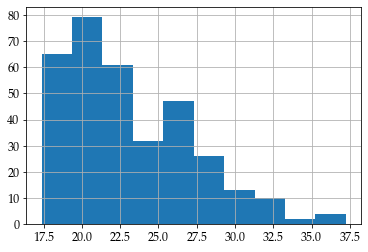

In [57]:
data_900_modelling.bmi.hist()

In [89]:
data_900_modelling.bmi.mean()

23.148549257934846

In [122]:
data_900_modelling.bmi.max()

37.242772377225094

In [90]:
data_900_modelling.bmi.std()

4.114683615220958

In [101]:
data_900_modelling.columns[data_900_modelling.columns.str[:2]=='ds']

Index(['ds1_date', 'ds1_day', 'ds1_e2', 'ds1_lh', 'ds1_prg',
       'ds1_bubble_count_r', 'ds1_bubble_count_l', 'ds1_mucosa_thick',
       'ds_date', 'ds_day',
       ...
       'ds1_3_dawka', 'ds1_7_dawka', 'ds4_7_dawka', 'ds1_3_dawka_dzienna',
       'ds1_7_dawka_dzienna', 'ds4_7_dawka_dzienna', 'ds1_dc_limited_by_4',
       'ds1_dc_limited_by_4_cat', 'ds1_dc_limited_by_8',
       'ds1_dc_limited_by_8_cat'],
      dtype='object', length=113)

<AxesSubplot:>

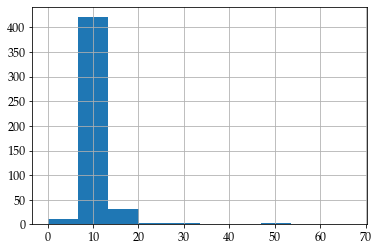

In [58]:
((data_900_modelling.ds_day - data_900_modelling.ds1_day)).hist()

In [59]:
((data_900_modelling.ds_day - data_900_modelling.ds1_day)).loc[((data_900_modelling.ds_day - data_900_modelling.ds1_day))<40].mean()

9.767590618336888

In [60]:
((data_900_modelling.ds_day - data_900_modelling.ds1_day)).loc[((data_900_modelling.ds_day - data_900_modelling.ds1_day))<40].std()

3.1000645765946717

<AxesSubplot:>

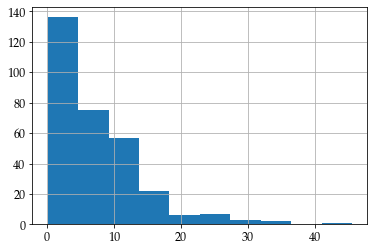

In [61]:
data_900_modelling.ds_1_result_num_LH.hist()

In [64]:
data_900_modelling.ds_1_result_num_LH.loc[data_900_modelling.ds_1_result_num_LH<20].mean()

6.0993127147766275

In [65]:
data_900_modelling.ds_1_result_num_LH.loc[data_900_modelling.ds_1_result_num_LH<20].std()

4.629954890129153

<AxesSubplot:>

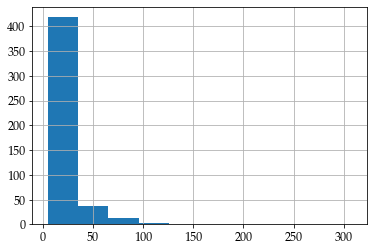

In [70]:
data_900_modelling.ds_1_result_num_E2.loc[data_900_modelling.ds_1_result_num_E2<500].hist()

In [71]:
data_900_modelling.ds_1_result_num_E2.loc[data_900_modelling.ds_1_result_num_E2<100].mean()

16.62208067940552

In [72]:
data_900_modelling.ds_1_result_num_E2.loc[data_900_modelling.ds_1_result_num_E2<100].std()

16.732611193824194

<AxesSubplot:>

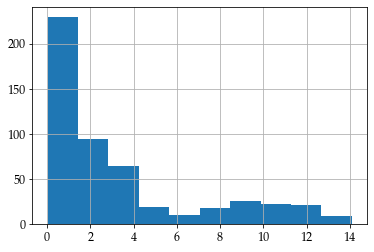

In [73]:
data_900_modelling.test_amh_r.hist()

In [124]:
data_900_modelling.test_amh_r.mean()

3.3831976744186067

In [125]:
data_900_modelling.test_amh_r.std()

3.674439082439344

<AxesSubplot:>

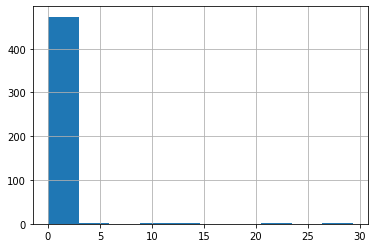

In [129]:
data_900_modelling.ds_1_result_num_PRG.hist()

In [127]:
data_900_modelling.ds_1_result_num_PRG.mean()

0.5861250000000013

In [128]:
data_900_modelling.ds_1_result_num_PRG.std()

2.112948050100074

In [130]:
data_900_modelling.dslast_pech_licz_14_pow.mean()

8.01673640167364

In [131]:
data_900_modelling.dslast_pech_licz_14_pow.std()

6.076360026484638

<AxesSubplot:>

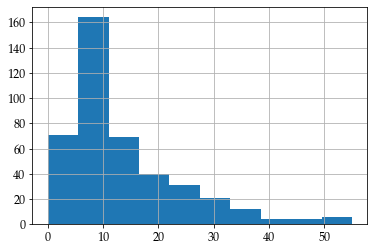

In [74]:
data_900_modelling.ds1_pech_licz_10_pon.hist()

In [222]:
data_900_modelling.ds1_pech_licz_10_pon.mean()

13.40521327014218

In [233]:
data_900_modelling.dslast_pech_licz.mean()

9.820083682008368

In [223]:
data_900_modelling.ds1_pech_licz_10_pon.std()

10.241004224762579

In [224]:
data_900_modelling['prev_proc-cumulus_denuded'].mean()

7.545112781954887

In [225]:
data_900_modelling['prev_proc-cumulus_denuded'].std()

6.147850873646069

In [228]:
data_900_modelling['prev_proc-day_0_mii'].mean()

5.8522727272727275

In [230]:
data_900_modelling['prev_proc-day_0_mii'].std()

4.585992325936663

In [231]:
data_900_modelling.cumulus_denuded.mean()

7.670542635658915

In [232]:
data_900_modelling.cumulus_denuded.std()

6.080366661156303

In [22]:
data_900_modelling.cumulus_count.mean()

8.959302325581396

In [23]:
data_900_modelling.cumulus_count.std()

7.04357385963892

In [226]:
data_900_modelling.cumulus_denuded.mean()

7.670542635658915

In [227]:
data_900_modelling.cumulus_denuded.std()

6.080366661156303

In [26]:
data_900_modelling.day_0_mii.mean()

5.920542635658915

In [24]:
data_900_modelling.day_0_mii.std()

4.753688858478985

In [56]:
data_900_modelling.test_fsh_r.loc[data_900_modelling.test_fsh_r<20].shape

(516, 4567)

In [53]:
data_900_modelling.test_fsh_r.loc[data_900_modelling.test_fsh_r<20].mean()

7.251282051282052

In [54]:
data_900_modelling.test_fsh_r.loc[data_900_modelling.test_fsh_r<20].std()

3.53294476576534

In [123]:
data_900_modelling.test_fsh_r.max()

34.6

<AxesSubplot:>

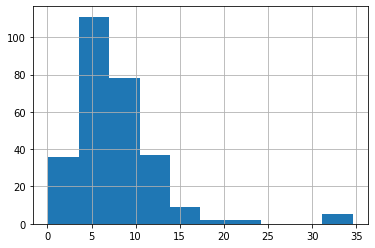

In [124]:
data_900_modelling.test_fsh_r.hist()

In [128]:
(data_900_modelling.test_fsh_r>15).sum()

11

In [29]:
data_900_modelling.test_fsh_r.std()

5.142964611723456

In [389]:
data_900_modelling.loc[(data_900_modelling.patient_age>36)&(data_900_modelling.test_amh_r<1)&(data_900_modelling.day_0_mii>3)][["patient_age","test_amh_r","day_0_mii"]]

patient_age  test_amh_r  day_0_mii
4             38        0.21        6.0
45            37        0.81        7.0
134           38        0.37        4.0
176           38        0.41        5.0
184           37        0.22        4.0
231           39        0.96        5.0
286           37        0.60        6.0
297           37        0.50        8.0
305           37        0.54        8.0
397           37        0.49        6.0
414           37        0.45        7.0
434           37        0.57        4.0
451           42        0.71        4.0

Correlation between age and amh

In [ ]:
from scipy.stats import pearsonr

In [ ]:
pearsonr(data_900_modelling.patient_age,data_900_modelling.test_amh_r)

(-0.1744427010649135, 6.789338592984807e-05)

In [ ]:
pearsonr(data_900_modelling.day_0_mii,data_900_modelling.test_amh_r)

(0.6435719463114591, 1.1244539428536921e-61)

In [ ]:
pearsonr(data_900_modelling.day_0_mii,data_900_modelling.patient_age)

(-0.18093115238768087, 3.5624471762911874e-05)

# Basic statistics - no genetic data

In [26]:
RMSE(data_2015_modelling.day_0_mii,data_2015_modelling.day_0_mii.mean())

4.6419240314287755

In [27]:
data_2015_modelling.test_amh_r.median()

2.31

In [28]:
print(data_2015_modelling.test_amh_r.mean(), data_2015_modelling.test_amh_r.std())

2.9800068812689573 2.419340281264021


In [164]:
print(data_2015_modelling.test_amh_r.min(), data_2015_modelling.test_amh_r.max())

0.02 14.88


In [104]:
data_2015_modelling.patient_age.min()

19

In [105]:
data_2015_modelling.patient_age.max()

51

In [31]:
print(data_2015_modelling.patient_age.mean(), data_2015_modelling.patient_age.std())

34.508397480755775 4.535677038108619


To calculate bmi you need to connect to INVICTA database - not available for commercial use. Only results are shown.

<AxesSubplot:>

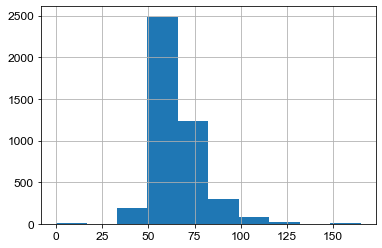

In [73]:
pd.to_numeric(data_2015_modelling_bmi.weight, errors = 'coerce').hist()

<AxesSubplot:>

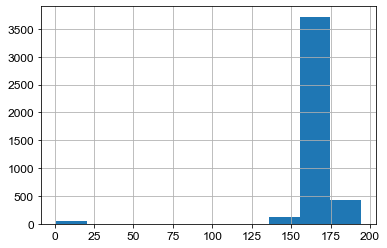

In [74]:
pd.to_numeric(data_2015_modelling_bmi.height, errors = 'coerce').hist()

<AxesSubplot:>

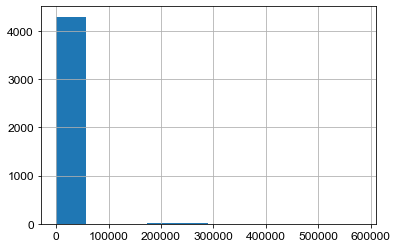

In [67]:
data_2015_modelling_bmi.bmi.hist()

Some of patients didn't use metric system - observations removed.

In [83]:
data_2015_modelling_bmi[data_2015_modelling_bmi.bmi<100].bmi.max()

64.47529765436494

In [84]:
data_2015_modelling_bmi[data_2015_modelling_bmi.bmi<100].bmi.mean()

23.427617461741246

In [85]:
data_2015_modelling_bmi[data_2015_modelling_bmi.bmi<100].bmi.std()

4.624926099849264

In [163]:
print(data_2015_modelling_bmi[(data_2015_modelling_bmi.bmi<100)&(data_2015_modelling_bmi.bmi>2)].bmi.min(),data_2015_modelling_bmi[data_2015_modelling_bmi.bmi<100].bmi.max())

14.701460122289419 64.47529765436494


In [86]:
print(data_2015_modelling_bmi[data_2015_modelling_bmi.bmi<100].weight.mean(),data_2015_modelling_bmi[data_2015_modelling_bmi.bmi<100].weight.std())

65.19471097589516 13.241168179347284


In [157]:
print(data_2015_modelling_bmi[(data_2015_modelling_bmi.weight>30)&(data_2015_modelling_bmi.weight<300)].weight.min(),data_2015_modelling_bmi[data_2015_modelling_bmi.bmi<100].weight.max())

40.0 165.0


In [87]:
print(data_2015_modelling_bmi[data_2015_modelling_bmi.bmi<100].height.mean(),data_2015_modelling_bmi[data_2015_modelling_bmi.bmi<100].height.std())

166.80177860987595 6.01494523035715


In [160]:
print(data_2015_modelling_bmi[(data_2015_modelling_bmi.height>100)&(data_2015_modelling_bmi.height<300)].height.min(),data_2015_modelling_bmi[(data_2015_modelling_bmi.height>30)&(data_2015_modelling_bmi.height<300)].height.max())

142.0 194.0


<AxesSubplot:>

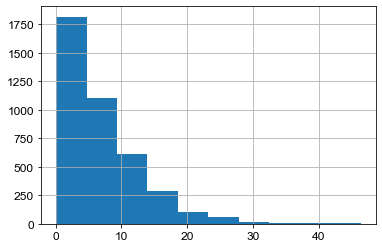

In [69]:
data_2015_modelling.ds_1_result_num_LH.hist()

In [70]:
data_2015_modelling.ds_1_result_num_LH.loc[data_2015_modelling.ds_1_result_num_LH<20].mean()

6.228859030837013

In [71]:
data_2015_modelling.ds_1_result_num_LH.loc[data_2015_modelling.ds_1_result_num_LH<20].std()

4.629294932227502

In [172]:
print(
    data_2015_modelling.loc[
        data_2015_modelling.ds_1_result_num_LH < 20
    ].ds_1_result_num_LH.min(),
    data_2015_modelling.loc[
        data_2015_modelling.ds_1_result_num_LH < 20
    ].ds_1_result_num_LH.max(),
)

0.1 19.9


<AxesSubplot:>

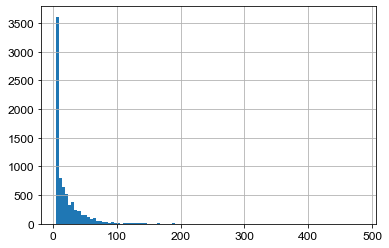

In [170]:
data_2015_modelling.ds_1_result_num_E2.loc[data_2015_modelling.ds_1_result_num_E2<500].hist(bins = 100)

In [73]:
data_2015_modelling.ds_1_result_num_E2.loc[data_2015_modelling.ds_1_result_num_E2<100].mean()

18.617754052985365

In [74]:
data_2015_modelling.ds_1_result_num_E2.loc[data_2015_modelling.ds_1_result_num_E2<100].std()

18.50271288111844

In [169]:
print(data_2015_modelling.ds_1_result_num_E2.loc[data_2015_modelling.ds_1_result_num_E2<100].min(), data_2015_modelling.loc[data_2015_modelling.ds_1_result_num_E2<90].ds_1_result_num_E2.max())

5.0 89.0


<AxesSubplot:>

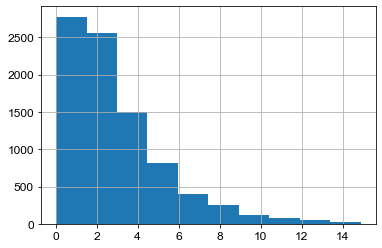

In [75]:
data_2015_modelling.test_amh_r.hist()

In [76]:
data_2015_modelling.test_amh_r.mean()

2.9800068812689573

In [77]:
data_2015_modelling.test_amh_r.std()

2.419340281264021

<AxesSubplot:>

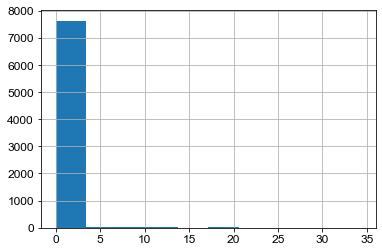

In [78]:
data_2015_modelling.ds_1_result_num_PRG.hist()

In [90]:
data_2015_modelling.loc[data_2015_modelling.ds_1_result_num_PRG<5].ds_1_result_num_PRG.mean()

0.3248595322095937

In [91]:
data_2015_modelling.loc[data_2015_modelling.ds_1_result_num_PRG<5].ds_1_result_num_PRG.std()

0.4174293693048226

In [175]:
print(
    data_2015_modelling.loc[
        data_2015_modelling.ds_1_result_num_PRG < 5
    ].ds_1_result_num_PRG.min(),
    data_2015_modelling.loc[
        data_2015_modelling.ds_1_result_num_PRG < 5
    ].ds_1_result_num_PRG.max(),
)

0.03 4.85


<AxesSubplot:>

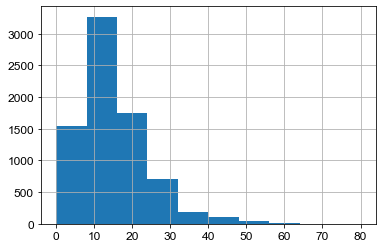

In [177]:
data_2015_modelling.ds1_pech_licz_2_8.hist()

In [93]:
print(data_2015_modelling.ds1_pech_licz_2_8.mean(),data_2015_modelling.ds1_pech_licz_2_8.std())

14.558730991085474 9.021314798395624


In [176]:
print(
    data_2015_modelling.loc[
        data_2015_modelling.ds1_pech_licz_2_8 < 5
    ].ds1_pech_licz_2_8.min(),
    data_2015_modelling.loc[
        data_2015_modelling.ds1_pech_licz_2_8 > 5
    ].ds1_pech_licz_2_8.max(),
)

0.0 80.0


In [94]:
print(data_2015_modelling.ds1_pech_licz_3_8.mean(),data_2015_modelling.ds1_pech_licz_3_8.std())

7.794572627163084 8.64722486563505


In [179]:
print(
    data_2015_modelling.loc[
        data_2015_modelling.ds1_pech_licz_3_8 < 5
    ].ds1_pech_licz_3_8.min(),
    data_2015_modelling.loc[
        data_2015_modelling.ds1_pech_licz_3_8 > 5
    ].ds1_pech_licz_3_8.max(),
)

0.0 73.0


In [ ]:
print(
    data_2015_modelling.loc[
        data_2015_modelling.ds_1_result_num_PRG < 5
    ].ds_1_result_num_PRG.min(),
    data_2015_modelling.loc[
        data_2015_modelling.ds_1_result_num_PRG < 5
    ].ds_1_result_num_PRG.max(),
)

In [95]:
print(data_2015_modelling.ds1_pech_licz_11_pow.mean(),data_2015_modelling.ds1_pech_licz_11_pow.std())

0.1430256948085999 0.8171620991484396


In [181]:
print(
    data_2015_modelling.loc[
        data_2015_modelling.ds1_pech_licz_11_pow < 100
    ].ds1_pech_licz_11_pow.min(),
    data_2015_modelling.loc[
        data_2015_modelling.ds1_pech_licz_11_pow > 5
    ].ds1_pech_licz_11_pow.max(),
)

0.0 19.0


In [100]:
print(data_2015_modelling.ds1_pech_licz_14_pow.mean(),data_2015_modelling.ds1_pech_licz_14_pow.std())

0.10959622443628736 0.6373680595354695


In [182]:
print(
    data_2015_modelling.loc[
        data_2015_modelling.ds1_pech_licz_14_pow < 100
    ].ds1_pech_licz_14_pow.min(),
    data_2015_modelling.loc[
        data_2015_modelling.ds1_pech_licz_14_pow > 5
    ].ds1_pech_licz_14_pow.max(),
)

0.0 16.0


In [101]:
print(data_2015_modelling.ds1_pech_licz_18_pow.mean(),data_2015_modelling.ds1_pech_licz_18_pow.std())

0.062401678028316726 0.3856439126760627


In [183]:
print(
    data_2015_modelling.loc[
        data_2015_modelling.ds1_pech_licz_18_pow < 100
    ].ds1_pech_licz_18_pow.min(),
    data_2015_modelling.loc[
        data_2015_modelling.ds1_pech_licz_18_pow > 5
    ].ds1_pech_licz_18_pow.max(),
)

0.0 10.0


In [102]:
print(data_2015_modelling.ds1_pech_licz_16_22.mean(),data_2015_modelling.ds1_pech_licz_16_22.std())

0.05506030414263241 0.45527295006541413


In [185]:
print(
    data_2015_modelling.loc[
        data_2015_modelling.ds1_pech_licz_16_22 < 100
    ].ds1_pech_licz_16_22.min(),
    data_2015_modelling.loc[
        data_2015_modelling.ds1_pech_licz_16_22 > 5
    ].ds1_pech_licz_16_22.max(),
)

0.0 16.0


In [103]:
print(data_2015_modelling.pickup_no_4m_prev.mean(),data_2015_modelling.pickup_no_4m_prev.std())

0.22964777233496617 0.4969079167151931


In [187]:
print(
    data_2015_modelling.loc[
        data_2015_modelling.pickup_no_4m_prev < 100
    ].pickup_no_4m_prev.min(),
    data_2015_modelling.loc[
        data_2015_modelling.pickup_no_4m_prev > 1
    ].pickup_no_4m_prev.max(),
)

0 4


In [109]:
print(data_2015_modelling["prev_proc-ds1_3_dawka_dzienna"].mean(),data_2015_modelling["prev_proc-ds1_3_dawka_dzienna"].std())

240.97222222222223 67.2611493401562


In [190]:
print(
    data_2015_modelling.loc[
        data_2015_modelling['prev_proc-ds1_3_dawka_dzienna'] > 0
    ]['prev_proc-ds1_3_dawka_dzienna'].min(),
    data_2015_modelling.loc[
        data_2015_modelling['prev_proc-ds1_3_dawka_dzienna'] > 1
    ]['prev_proc-ds1_3_dawka_dzienna'].max(),
)

75.0 1275.0


In [110]:
print(data_2015_modelling["prev_proc-ds4_7_dawka_dzienna"].mean(),data_2015_modelling["prev_proc-ds4_7_dawka_dzienna"].std())

207.22222222222223 56.00274548908807


In [191]:
print(
    data_2015_modelling.loc[
        data_2015_modelling['prev_proc-ds4_7_dawka_dzienna'] > 0
    ]['prev_proc-ds4_7_dawka_dzienna'].min(),
    data_2015_modelling.loc[
        data_2015_modelling['prev_proc-ds4_7_dawka_dzienna'] > 1
    ]['prev_proc-ds4_7_dawka_dzienna'].max(),
)

75.0 375.0


In [125]:
print(
    data_2015_modelling["prev_proc-denuded_per_bubbles"]
    .loc[data_2015_modelling["prev_proc-denuded_per_bubbles"] < 100]
    .mean(),
    data_2015_modelling["prev_proc-denuded_per_bubbles"]
    .loc[data_2015_modelling["prev_proc-denuded_per_bubbles"] < 100]
    .std(),
)

0.6592951682830176 0.4303700306099953


In [193]:
print(
    data_2015_modelling["prev_proc-denuded_per_bubbles"]
    .loc[data_2015_modelling["prev_proc-denuded_per_bubbles"] < 100]
    .min(),
    data_2015_modelling["prev_proc-denuded_per_bubbles"]
    .loc[data_2015_modelling["prev_proc-denuded_per_bubbles"] < 100]
    .max(),
)

0.0 5.5


In [126]:
print(
    data_2015_modelling["prev_proc-mii_per_bubbles"]
    .loc[data_2015_modelling["prev_proc-mii_per_bubbles"] < 100]
    .mean(),
    data_2015_modelling["prev_proc-mii_per_bubbles"]
    .loc[data_2015_modelling["prev_proc-mii_per_bubbles"] < 100]
    .std(),
)

0.4976097287516968 0.3627694365057492


In [194]:
print(
    data_2015_modelling["prev_proc-mii_per_bubbles"]
    .loc[data_2015_modelling["prev_proc-mii_per_bubbles"] < 100]
    .min(),
    data_2015_modelling["prev_proc-mii_per_bubbles"]
    .loc[data_2015_modelling["prev_proc-mii_per_bubbles"] < 100]
    .max(),
)

0.0 4.333333333333333


<AxesSubplot:>

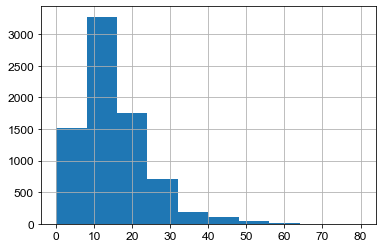

In [83]:
data_2015_modelling.ds1_pech_licz_10_pon.hist()

In [84]:
data_2015_modelling.ds1_pech_licz_10_pon.mean()

14.629129522810697

In [86]:
data_2015_modelling.ds1_pech_licz_10_pon.std()

8.986709936155727

In [85]:
data_2015_modelling.dslast_pech_licz.mean()

11.615575221238938

In [87]:
data_2015_modelling['prev_proc-cumulus_denuded'].mean()

8.260585305105852

In [88]:
data_2015_modelling['prev_proc-cumulus_denuded'].std()

5.263735427505035

In [196]:
print(
    data_2015_modelling["prev_proc-cumulus_denuded"]
    .loc[data_2015_modelling["prev_proc-cumulus_denuded"] < 100]
    .min(),
    data_2015_modelling["prev_proc-cumulus_denuded"]
    .loc[data_2015_modelling["prev_proc-cumulus_denuded"] < 100]
    .max(),
)

0.0 36.0


In [91]:
data_2015_modelling['prev_proc-day_0_mii'].mean()

6.1669281455914655

In [92]:
data_2015_modelling['prev_proc-day_0_mii'].std()

4.1028519709879445

In [195]:
print(
    data_2015_modelling["prev_proc-day_0_mii"]
    .loc[data_2015_modelling["prev_proc-day_0_mii"] < 100]
    .min(),
    data_2015_modelling["prev_proc-day_0_mii"]
    .loc[data_2015_modelling["prev_proc-day_0_mii"] < 100]
    .max(),
)

0.0 32.0


In [93]:
data_2015_modelling.cumulus_denuded.mean()

9.140191275950547

In [95]:
data_2015_modelling.cumulus_denuded.std()

5.824341562361581

In [96]:
data_2015_modelling.cumulus_count.mean()

10.682178679729414

In [97]:
data_2015_modelling.cumulus_count.std()

6.593095378680213

In [98]:
data_2015_modelling.cumulus_denuded.mean()

9.140191275950547

In [99]:
data_2015_modelling.cumulus_denuded.std()

5.824341562361581

In [100]:
data_2015_modelling.day_0_mii.mean()

6.960928388150221

In [101]:
data_2015_modelling.day_0_mii.std()

4.642194752802547

In [117]:
data_2015_modelling.qual_result_num_FSH.loc[data_2015_modelling.qual_result_num_FSH<20].mean()

6.461371632153172

In [118]:
data_2015_modelling.qual_result_num_FSH.loc[data_2015_modelling.qual_result_num_FSH<20].std()

2.830120986763742

In [ ]:
data_2015_modelling.test_fsh_r.max()

34.6

<AxesSubplot:>

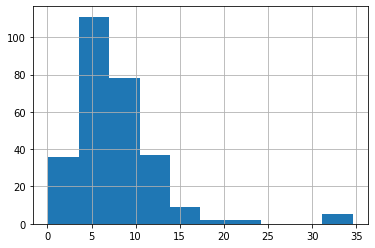

In [ ]:
data_2015_modelling.test_fsh_r.hist()

In [ ]:
(data_2015_modelling.test_fsh_r>15).sum()

11

In [ ]:
data_2015_modelling.test_fsh_r.std()

5.142964611723456

In [105]:
data_2015_modelling.sum_dose_Gonadotropiny.mean()

2109.7641754140423

In [106]:
data_2015_modelling.sum_dose_Gonadotropiny.std()

826.6226088627113

# Statistical difference between dataset with and without genetic data

In [56]:
from scipy.stats import pearsonr, ttest_ind, f_oneway, shapiro,levene,bartlett, mannwhitneyu

In [62]:
data_2015_modelling['test_fsh_r'] = data_2015_modelling['qual_result_num_FSH']

In [57]:
def check_anova(x,y):
    sh1=shapiro(x)
    sh2=shapiro(y)
    lv = levene(x,y)
    print(f"Shapiro test, genetic dataset: statistic =  {sh1[0]}, p_value = {sh1[1]}")
    print(f"Shapiro test, no gene dataset: statistic =  {sh2[0]}, p_value = {sh2[1]}")
    print(f"Levene test : statistic =  {lv[0]}, p_value = {lv[1]}")
    anova_allowed = (sh1[1]>0.05)&(sh2[1]>0.05)&(lv[1]>0.05)
    return anova_allowed

In [59]:
def check_statistic_significance(column):
    print('------------------------')
    print(f'-------{column}-------')
    anova_allowed = check_anova(data_900_modelling[column],data_2015_modelling[column])
    if anova_allowed:
        wyniki_testu = f_oneway(data_900_modelling[column],data_2015_modelling[column])
        print("ANOVA: statistic = {}, p_value = {}".format(wyniki_testu[0],wyniki_testu[1]))
        are_different = wyniki_testu[1]<0.05
    else:
        wyniki_testu = mannwhitneyu(data_900_modelling[column],data_2015_modelling[column])
        print("U : statistic = {}, p_value = {}".format(wyniki_testu[0],wyniki_testu[1]))
        are_different = wyniki_testu[1]<0.05
    return are_different

In [60]:
statistics_columns = [
    'day_0_mii',
    'test_amh_r',
    'patient_age',
    'ds_1_result_num_LH',
    'ds_1_result_num_E2',
    'ds_1_result_num_PRG',
    'ds1_pech_licz_10_pon',
    'prev_proc-cumulus_denuded',
    'prev_proc-day_0_mii',
    'cumulus_denuded',
    'test_fsh_r',
]

In [63]:
results = {}
for column in statistics_columns:
    results[column] = check_statistic_significance(column)

------------------------
-------day_0_mii-------
Shapiro test, genetic dataset: statistic =  0.8755047917366028, p_value = 6.589101685982063e-20
Shapiro test, no gene dataset: statistic =  0.924079418182373, p_value = 0.0
Levene test : statistic =  0.05075714491429898, p_value = 0.8217560496129361
U : statistic = 1846221.5, p_value = 1.1604572232997863e-10
------------------------
-------test_amh_r-------
Shapiro test, genetic dataset: statistic =  0.7870419025421143, p_value = 2.0670215383310235e-25
Shapiro test, no gene dataset: statistic =  0.855137288570404, p_value = 0.0
Levene test : statistic =  99.9811375240913, p_value = 2.0325112276425398e-23
U : statistic = 2003273.0, p_value = 0.00015491844527243926
------------------------
-------patient_age-------
Shapiro test, genetic dataset: statistic =  0.9886894822120667, p_value = 0.0005098565015941858
Shapiro test, no gene dataset: statistic =  0.9933484792709351, p_value = 1.4150122497138033e-19
Levene test : statistic =  6.449870

p-value may not be accurate for N > 5000.


In [64]:
pd.Series(results)

day_0_mii                     True
test_amh_r                    True
patient_age                  False
ds_1_result_num_LH            True
ds_1_result_num_E2            True
ds_1_result_num_PRG           True
ds1_pech_licz_10_pon          True
prev_proc-cumulus_denuded     True
prev_proc-day_0_mii           True
cumulus_denuded               True
test_fsh_r                    True
dtype: bool

## Haplotype freq

### Unzipped

In [153]:
def get_position(x: str):
    return x.split("_")[2]

In [154]:
def get_variants_from_haplotypes(DATA_PATH: str,chr: str,method: str,block: int,variants_list: list, haplotype:str):
    blocks, haplotypes = read_haploview_file(
        f"{DATA_PATH}/poprawne_vcf_haplotypes/haplotypes/hmap/hmap_invicta.{chr}.hmap.{method}blocks",
        False,
    )
    patient_ids, locus_infos, locus_dict, patient_genome = \
        read_hmap_file(f"{DATA_PATH}/poprawne_vcf_haplotypes/haplotypes/hmap/hmap_invicta.{chr}.hmap")
    positions = []
    for i in blocks[block]:
        positions.append(int(locus_infos[i-1].pos))
    chr2_variants_cols = [x for x in variants_list if int(x.split('_')[3]) in positions]
    sorted_ch2_variants_cols = sorted(chr2_variants_cols,key=get_position)
    return(positions,dict(zip(sorted_ch2_variants_cols,list(haplotype.split("_")[3]))))

In [156]:
GENOME_COLS = [col for col in data_900_df.columns if col[:6]=='genome']

chr2_4GAM_block4_ACCACATGCCAGCGAAGACAAA

In [157]:
chr2_4GAM_block4_positions, chr2_4GAM_block4_haplotypes_variants =  get_variants_from_haplotypes(DATA_PATH,'chr2','4GAM',4,GENOME_COLS,"chr2_4GAM_block4_ACCACATGCCAGCGAAGACAAA")

In [170]:
chr2_4GAM_block4_haplotypes_variants

{'genome_012_chr2_48755846_A_G': 'A',
 'genome_012_chr2_48961885_C_T': 'C',
 'genome_012_chr2_48962033_C_T': 'C',
 'genome_012_chr2_48962060_A_G': 'A',
 'genome_012_chr2_48962210_C_T': 'C',
 'genome_012_chr2_48962487_A_T': 'A',
 'genome_012_chr2_48962782_C_T': 'T',
 'genome_012_chr2_48963138_G_A': 'G',
 'genome_012_chr2_48963491_C_T': 'C',
 'genome_012_chr2_48963599_C_A': 'C',
 'genome_012_chr2_48963670_A_G': 'A',
 'genome_012_chr2_48963773_G_T': 'G',
 'genome_012_chr2_48963859_C_G': 'C',
 'genome_012_chr2_48968573_G_C': 'G',
 'genome_012_chr2_48968886_A_G': 'A',
 'genome_012_chr2_48982928_A_C': 'A',
 'genome_012_chr2_48982977_G_A': 'G',
 'genome_012_chr2_48988980_A_G': 'A',
 'genome_012_chr2_48989016_C_T': 'C',
 'genome_012_chr2_48989135_A_T': 'A',
 'genome_012_chr2_48990555_A_G': 'A',
 'genome_012_chr2_48990619_A_G': 'A'}

In [210]:
(data_900_modelling_unique_patients[list(chr2_4GAM_block4_haplotypes_variants.keys())]>0).mean()

genome_012_chr2_48755846_A_G    0.011364
genome_012_chr2_48961885_C_T    0.003788
genome_012_chr2_48962033_C_T    0.003788
genome_012_chr2_48962060_A_G    0.090909
genome_012_chr2_48962210_C_T    0.003788
genome_012_chr2_48962487_A_T    0.090909
genome_012_chr2_48962782_C_T    0.708333
genome_012_chr2_48963138_G_A    0.000000
genome_012_chr2_48963491_C_T    0.000000
genome_012_chr2_48963599_C_A    0.003788
genome_012_chr2_48963670_A_G    0.003788
genome_012_chr2_48963773_G_T    0.003788
genome_012_chr2_48963859_C_G    0.000000
genome_012_chr2_48968573_G_C    0.000000
genome_012_chr2_48968886_A_G    0.003788
genome_012_chr2_48982928_A_C    0.003788
genome_012_chr2_48982977_G_A    0.003788
genome_012_chr2_48988980_A_G    0.003788
genome_012_chr2_48989016_C_T    0.015152
genome_012_chr2_48989135_A_T    0.000000
genome_012_chr2_48990555_A_G    0.007576
genome_012_chr2_48990619_A_G    0.003788
dtype: float64

In [205]:
all_block_cols.index('chr2_4GAM_block4_ACCACATGCCAGCGAAGACAAA')

162

In [212]:
(data_900_modelling_unique_patients.chr2_4GAM_block4_ACCACATGCCAGCGAAGACAAA*1).mean()

0.5643939393939394

chr5_4GAM_block2_CATCAGTTACACAGTTAGACAGCCACGTGTCGTCGGTGGTC 

In [174]:
chr5_4GAM_block2_positions, chr5_4GAM_block2_haplotypes_variants =  get_variants_from_haplotypes(DATA_PATH,'chr5','4GAM',2,GENOME_COLS,"chr5_4GAM_block2_CATCAGTTACACAGTTAGACAGCCACGTGTCGTCGGTGGTC")

In [175]:
chr5_4GAM_block2_haplotypes_variants

{'genome_012_chr5_35060399_C_T': 'C',
 'genome_012_chr5_35060411_A_G': 'A',
 'genome_012_chr5_35060629_T_C': 'T',
 'genome_012_chr5_35060923_C_A': 'C',
 'genome_012_chr5_35061009_A_G': 'A',
 'genome_012_chr5_35061154_G_T': 'G',
 'genome_012_chr5_35061629_T_C': 'T',
 'genome_012_chr5_35061761_T_C': 'T',
 'genome_012_chr5_35061871_A_G': 'A',
 'genome_012_chr5_35061973_C_T': 'C',
 'genome_012_chr5_35062253_A_T': 'A',
 'genome_012_chr5_35062516_C_T': 'C',
 'genome_012_chr5_35062627_A_G': 'A',
 'genome_012_chr5_35063008_G_A': 'G',
 'genome_012_chr5_35063015_T_C': 'T',
 'genome_012_chr5_35063098_T_C': 'T',
 'genome_012_chr5_35063190_A_T': 'A',
 'genome_012_chr5_35063323_G_A': 'G',
 'genome_012_chr5_35064072_A_G': 'A',
 'genome_012_chr5_35064118_C_G': 'C',
 'genome_012_chr5_35064133_A_G': 'A',
 'genome_012_chr5_35064358_G_C': 'G',
 'genome_012_chr5_35064413_C_A': 'C',
 'genome_012_chr5_35064637_C_T': 'C',
 'genome_012_chr5_35064682_A_G': 'A',
 'genome_012_chr5_35064922_C_G': 'C',
 'genome_012

In [178]:
(data_900_modelling_unique_patients[list(chr5_4GAM_block2_haplotypes_variants.keys())]>0).mean()

genome_012_chr5_35060399_C_T    0.007576
genome_012_chr5_35060411_A_G    0.007576
genome_012_chr5_35060629_T_C    0.007576
genome_012_chr5_35060923_C_A    0.003788
genome_012_chr5_35061009_A_G    0.003788
genome_012_chr5_35061154_G_T    0.000000
genome_012_chr5_35061629_T_C    0.155303
genome_012_chr5_35061761_T_C    0.003788
genome_012_chr5_35061871_A_G    0.000000
genome_012_chr5_35061973_C_T    0.003788
genome_012_chr5_35062253_A_T    0.003788
genome_012_chr5_35062516_C_T    0.234848
genome_012_chr5_35062627_A_G    0.000000
genome_012_chr5_35063008_G_A    0.000000
genome_012_chr5_35063015_T_C    0.094697
genome_012_chr5_35063098_T_C    0.000000
genome_012_chr5_35063190_A_T    0.242424
genome_012_chr5_35063323_G_A    0.003788
genome_012_chr5_35064072_A_G    0.000000
genome_012_chr5_35064118_C_G    0.003788
genome_012_chr5_35064133_A_G    0.094697
genome_012_chr5_35064358_G_C    0.064394
genome_012_chr5_35064413_C_A    0.064394
genome_012_chr5_35064637_C_T    0.071970
genome_012_chr5_

In [213]:
(data_900_modelling_unique_patients.chr5_4GAM_block2_CATCAGTTACACAGTTAGACAGCCACGTGTCGTCGGTGGTC*1).mean()

0.5454545454545454

chr5_4GAM_block6_AGTGTTCTGGACGGCC

In [181]:
chr5_4GAM_block6_positions, chr5_4GAM_block6_haplotypes_variants =  get_variants_from_haplotypes(DATA_PATH,'chr5','4GAM',6,GENOME_COLS,"chr5_4GAM_block6_AGTGTTCTGGACGGCC")

In [182]:
chr5_4GAM_block6_haplotypes_variants

{'genome_012_chr5_132865408_A_G': 'A',
 'genome_012_chr5_132865453_G_A': 'G',
 'genome_012_chr5_132865691_T_C': 'T',
 'genome_012_chr5_132866060_G_A': 'G',
 'genome_012_chr5_132866082_T_A': 'T',
 'genome_012_chr5_132866205_T_C': 'T',
 'genome_012_chr5_132866215_C_T': 'C',
 'genome_012_chr5_132866313_T_A': 'T',
 'genome_012_chr5_132866484_G_C': 'G',
 'genome_012_chr5_132866553_G_A': 'G',
 'genome_012_chr5_132866657_A_C': 'A',
 'genome_012_chr5_132866707_T_C': 'C',
 'genome_012_chr5_132866719_C_G': 'G',
 'genome_012_chr5_132866743_G_A': 'G',
 'genome_012_chr5_132866746_C_T': 'C',
 'genome_012_chr5_132867052_C_T': 'C'}

In [183]:
(data_900_modelling_unique_patients[list(chr5_4GAM_block6_haplotypes_variants.keys())]>0).mean()

genome_012_chr5_132865408_A_G    0.003788
genome_012_chr5_132865453_G_A    0.003788
genome_012_chr5_132865691_T_C    0.003788
genome_012_chr5_132866060_G_A    0.003788
genome_012_chr5_132866082_T_A    0.310606
genome_012_chr5_132866205_T_C    0.291667
genome_012_chr5_132866215_C_T    0.003788
genome_012_chr5_132866313_T_A    0.000000
genome_012_chr5_132866484_G_C    0.003788
genome_012_chr5_132866553_G_A    0.003788
genome_012_chr5_132866657_A_C    0.003788
genome_012_chr5_132866707_T_C    0.920455
genome_012_chr5_132866719_C_G    0.920455
genome_012_chr5_132866743_G_A    0.003788
genome_012_chr5_132866746_C_T    0.000000
genome_012_chr5_132867052_C_T    0.068182
dtype: float64

In [214]:
(data_900_modelling_unique_patients.chr5_4GAM_block6_AGTGTTCTGGACGGCC*1).mean()

0.36363636363636365

### Zipped

In [58]:
data_900_modelling_unique_patients.chr5_4GAM_block2_haplotypes_variants.mean()

0.5795454545454546

In [17]:
(data_900_modelling_unique_patients[['genome_012_chr5_35063190_A_T',
 'genome_012_chr5_35064922_C_G',
 'genome_012_chr5_35068146_G_C',
 'genome_012_chr5_35061629_T_C',
 'genome_012_chr5_35069864_G_A',
 'genome_012_chr5_35064413_C_A',
 'genome_012_chr5_35062516_C_T',
 'genome_012_chr5_35065548_C_T']]>0).mean()

genome_012_chr5_35063190_A_T    0.242424
genome_012_chr5_35064922_C_G    0.068182
genome_012_chr5_35068146_G_C    0.087121
genome_012_chr5_35061629_T_C    0.155303
genome_012_chr5_35069864_G_A    0.015152
genome_012_chr5_35064413_C_A    0.064394
genome_012_chr5_35062516_C_T    0.234848
genome_012_chr5_35065548_C_T    0.007576
dtype: float64

In [61]:
data_900_modelling_unique_patients.chr2_4GAM_block4_haplotypes_variants.mean()

0.6515151515151515

In [ ]:
((data_900_df['genome_012_chr2_48962782_C_T']>0)&(data_900_df['genome_012_chr2_48962060_A_G']==0))*1

In [169]:
(data_900_modelling_unique_patients[['genome_012_chr2_48962782_C_T','genome_012_chr2_48962060_A_G']]>0).mean()

genome_012_chr2_48962782_C_T    0.708333
genome_012_chr2_48962060_A_G    0.090909
dtype: float64

In [ ]:
['genome_012_chr5_132866082_T_A',
 'genome_012_chr5_132866205_T_C',
 'genome_012_chr5_132866719_C_G']

In [219]:
data_900_modelling_unique_patients["chr5_4GAM_block6_haplotypes_variants"] = (
    (
        data_900_modelling_unique_patients[
            ["genome_012_chr5_132866082_T_A", "genome_012_chr5_132866205_T_C"]
        ].sum(axis=1)
        == 0
    )
    & (data_900_modelling_unique_patients.genome_012_chr5_132866719_C_G > 1)
) * 1

In [220]:
data_900_modelling_unique_patients.chr5_4GAM_block6_haplotypes_variants.mean()

0.17045454545454544

In [18]:

data_900_df['SOM_cols'] = data_900_df[[
"GDF9_5_132865538_T_C",
"GDF9_5_132866205_T_C",
"LHCGR_2_48729336_C_T",
"FSHB_11_30234435_A_G", 
"ESR1_6_152061190_A_G", 
"ESR2_14_64227477_C_T"]]

In [19]:
data_900_modelling_unique_patients[[
"GDF9_5_132865538_T_C",
"GDF9_5_132866205_T_C",
"LHCGR_2_48729336_C_T",
"FSHB_11_30234435_A_G", 
"ESR1_6_152061190_A_G", 
"ESR2_14_64227477_C_T"]].mean()

GDF9_5_132865538_T_C    0.515152
GDF9_5_132866205_T_C    0.287879
LHCGR_2_48729336_C_T    0.428030
FSHB_11_30234435_A_G    0.522727
ESR1_6_152061190_A_G    0.117424
ESR2_14_64227477_C_T    0.731061
dtype: float64

In [ ]:
data_900_modelling.chr5_4GAM_block2_haplotypes_variants.mean()

In [53]:
alter_prot(data_2015_df,SUMMARY_COLS,False)[SUMMARY_COLS].describe()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


test_amh_r  prev_proc-cumulus_denuded  prev_proc-day_0_mii  \
count  3187.000000                3187.000000          3187.000000   
mean      2.768685                   8.307813             6.166928   
std       2.289173                   5.244823             4.102852   
min       0.030000                   1.000000             0.000000   
25%       1.160000                   4.000000             3.000000   
50%       2.110000                   7.000000             5.000000   
75%       3.690000                  11.000000             8.000000   
max      14.700000                  36.000000            32.000000   

       patient_age    cause_pco    day_0_mii    day_0_mii     hiper_20  \
count  3187.000000  3187.000000  3187.000000  3187.000000  3187.000000   
mean     35.336680     0.048321     6.775965     6.775965     0.101349   
std       4.537482     0.214478     4.654546     4.654546     0.301838   
min      20.000000     0.000000     0.000000     0.000000     0.000000   
25%      32.000000     0.000000     3.000000     3.000000     0.000000   
50%      35.000000     0.000000     6.000000     6.000000     0.000000   
75%      39.000000     0.000000     9.000000     9.000000     0.000000   
max      51.000000     1.000000    34.000000    34.000000     1.000000   

          hiper_20  
count  3187.000000  
mean      0.101349  
std       0.301838  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000

In [49]:
SUMMARY_COLS = [
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "prot_progesteron",
    "prot_short_agonist",
    "prot_short_antagonista",
    "prot_long",
    "patient_age",
    "cause_pco",
    "day_0_mii",
    "hiper_20"
]

In [50]:
prot_stim_data_2015_no_genetic = alter_stim(data_2015_df,SUMMARY_COLS,False)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [51]:
prot_stim_data_2015_no_genetic.describe()

test_amh_r  ds1_pech_licz_10_pon  prev_proc-cumulus_denuded  \
count  2744.000000           2744.000000                2744.000000   
mean      2.776957             13.581268                   8.451531   
std       2.280914              8.467559                   5.326303   
min       0.030000              0.000000                   1.000000   
25%       1.180000              8.000000                   5.000000   
50%       2.110000             12.000000                   7.000000   
75%       3.710000             17.000000                  11.000000   
max      14.700000             74.000000                  36.000000   

       prev_proc-day_0_mii  prot_progesteron  prot_short_agonist  \
count          2744.000000       2744.000000         2744.000000   
mean              6.250729          0.159257            0.114796   
std               4.160711          0.365982            0.318834   
min               0.000000          0.000000            0.000000   
25%               3.000000          0.000000            0.000000   
50%               6.000000          0.000000            0.000000   
75%               8.000000          0.000000            0.000000   
max              32.000000          1.000000            1.000000   

       prot_short_antagonista    prot_long  patient_age    cause_pco  \
count             2744.000000  2744.000000   2744.00000  2744.000000   
mean                 0.142857     0.583090     35.16363     0.047012   
std                  0.349991     0.493138      4.51907     0.211702   
min                  0.000000     0.000000     20.00000     0.000000   
25%                  0.000000     0.000000     32.00000     0.000000   
50%                  0.000000     1.000000     35.00000     0.000000   
75%                  0.000000     1.000000     39.00000     0.000000   
max                  1.000000     1.000000     51.00000     1.000000   

         day_0_mii     hiper_20  
count  2744.000000  2744.000000  
mean      6.850948     0.103499  
std       4.698261     0.304664  
min       0.000000     0.000000  
25%       3.000000     0.000000  
50%       6.000000     0.000000  
75%       9.000000     0.000000  
max      34.000000     1.000000

## Wykres referencyjny

### Original data

In [11]:
N_FOLDS=5

In [12]:
DATA_SERIES_900 = {}
DATA_SERIES_900['900_cumulus_denuded'] = prepare_data_serie(data_900_df, 'cumulus_denuded', N_FOLDS)
DATA_SERIES_900['900_day_0_mii'] = prepare_data_serie(data_900_df, 'day_0_mii', N_FOLDS)

Original records: 906
Filtered records: 516
Original records: 906
Filtered records: 516


In [33]:
REF_COLS = [
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "patient_age",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "cause_pco"
]
REF_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    REF_COLS,
    model_suffixes_filter=['l2'])
REF_RESULTS.print_errors(
    [REF_RESULTS],
    print_suffixes=['l2'],
    print_avg=True,
)


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


-
RMSE[ test_fold_avg][l2][900_cumulus_denuded]: count:516    avg:7.67   4.46    (0.00)    
MAE[ test_fold_avg][l2][900_cumulus_denuded]:  count:516    avg:7.67   3.19    (0.00)    
MAPE[ test_fold_avg][l2][900_cumulus_denuded]: count:516    avg:7.67   0.76    (0.00)    
LIKELIHOOD[ test_fold_avg][l2][900_cumulus_denuded]: count:516    avg:7.67   5.52    (0.00)    
-----------------------------
-
RMSE[ test_fold_avg][l2][900_day_0_mii]:       count:516    avg:5.92   3.53    (0.00)    
MAE[ test_fold_avg][l2][900_day_0_mii]:        count:516    avg:5.92   2.58    (0.00)    
MAPE[ test_fold_avg][l2][900_day_0_mii]:       count:516    avg:5.92   0.71    (0.00)    
LIKELIHOOD[ test_fold_avg][l2][900_day_0_mii]: count:516    avg:5.92   3.30    (0.00)    
-----------------------------


### Renamed

In [13]:
data_900_renamed = data_900_df.copy()

In [14]:
data_900_renamed.rename(
    {
        #"test_amh_r": "AMH",
        "ds1_pech_licz_10_pon": "AFC on the first day of the stimulation",
        "patient_age": "Age",
        "prev_proc-cumulus_denuded": "Number of cumulus denuded in previous process",
        "prev_proc-day_0_mii": "Number of MII oocytes in previous process",
        "cause_pco": "PCOS",
        "SOM_cols": "SOM_variants",
        'chr2_4GAM_block4_ACCACATGCCAGCGAAGACAAA':'haplotype_ACCACATGCCAGCGAAGACAAA',
        'chr5_4GAM_block2_CATCAGTTACACAGTTAGACAGCCACGTGTCGTCGGTGGTC':'haplotype_CATCAGTTACACAGTTAGACAGCCACGTGTCGTCGGTGGTC',
        'chr5_4GAM_block6_AGTGTTCTGGACGGCC':'haplotype_AGTGTTCTGGACGGCC'
    }, axis = 1, inplace = True
)
data_900_renamed['AMH'] = data_900_renamed.test_amh_r

In [15]:
DATA_SERIES_900 = {}
DATA_SERIES_900['900_day_0_mii'] = prepare_data_serie(data_900_renamed, 'day_0_mii', N_FOLDS)

Original records: 906
Filtered records: 516


In [16]:
REF_COLS = [
    "AMH",
    "AFC on the first day of the stimulation",
    "Age",
    "Number of cumulus denuded in previous process",
    "Number of MII oocytes in previous process",
    "PCOS"
]

In [40]:
REF_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    REF_COLS,
    model_suffixes_filter=['l2', 'h20', 'h25', 'low', 'upp'])
REF_RESULTS.print_errors(
    [REF_RESULTS],
    print_suffixes=['l2', 'h20', 'h25', 'low', 'upp'],
    print_avg=True,
)

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


-
RMSE[ test_fold_avg][upp][900_day_0_mii]:      count:516    avg:5.92   3.96    (0.00)    
MAE[ test_fold_avg][upp][900_day_0_mii]:       count:516    avg:5.92   3.12    (0.00)    
MAPE[ test_fold_avg][upp][900_day_0_mii]:      count:516    avg:5.92   1.07    (0.00)    
LIKELIHOOD[ test_fold_avg][upp][900_day_0_mii]: count:516    avg:5.92   3.30    (0.00)    
-
RMSE[ test_fold_avg][l2][900_day_0_mii]:       count:516    avg:5.92   3.53    (0.00)    
MAE[ test_fold_avg][l2][900_day_0_mii]:        count:516    avg:5.92   2.58    (0.00)    
MAPE[ test_fold_avg][l2][900_day_0_mii]:       count:516    avg:5.92   0.71    (0.00)    
LIKELIHOOD[ test_fold_avg][l2][900_day_0_mii]: count:516    avg:5.92   3.30    (0.00)    
-
RMSE[ test_fold_avg][low][900_day_0_mii]:      count:516    avg:5.92   5.10    (0.00)    
MAE[ test_fold_avg][low][900_day_0_mii]:       count:516    avg:5.92   3.43    (0.00)    
MAPE[ test_fold_avg][low][900_day_0_mii]:      count:516    avg:5.92   0.51    (0.00)    
LIK

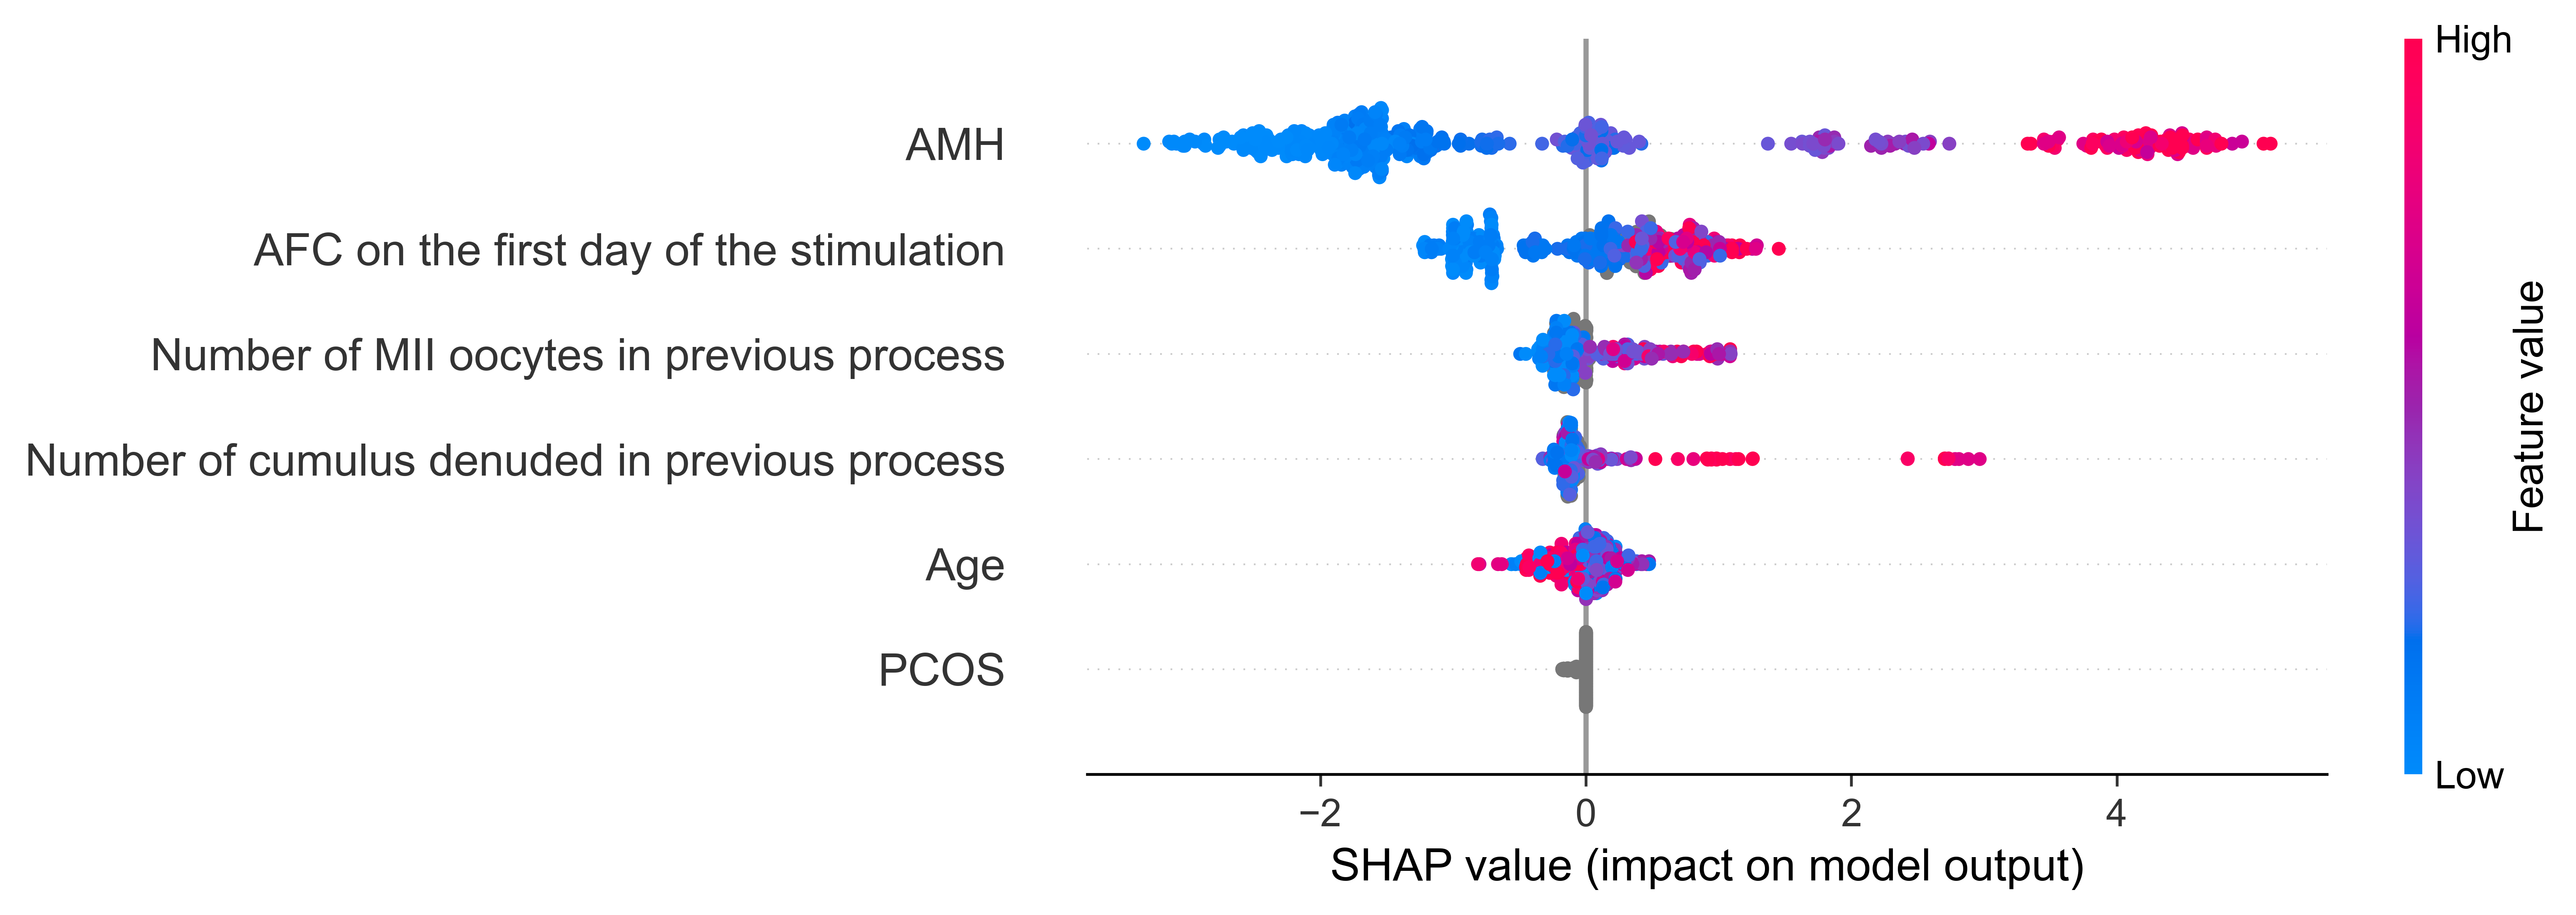

<Figure size 648x792 with 0 Axes>

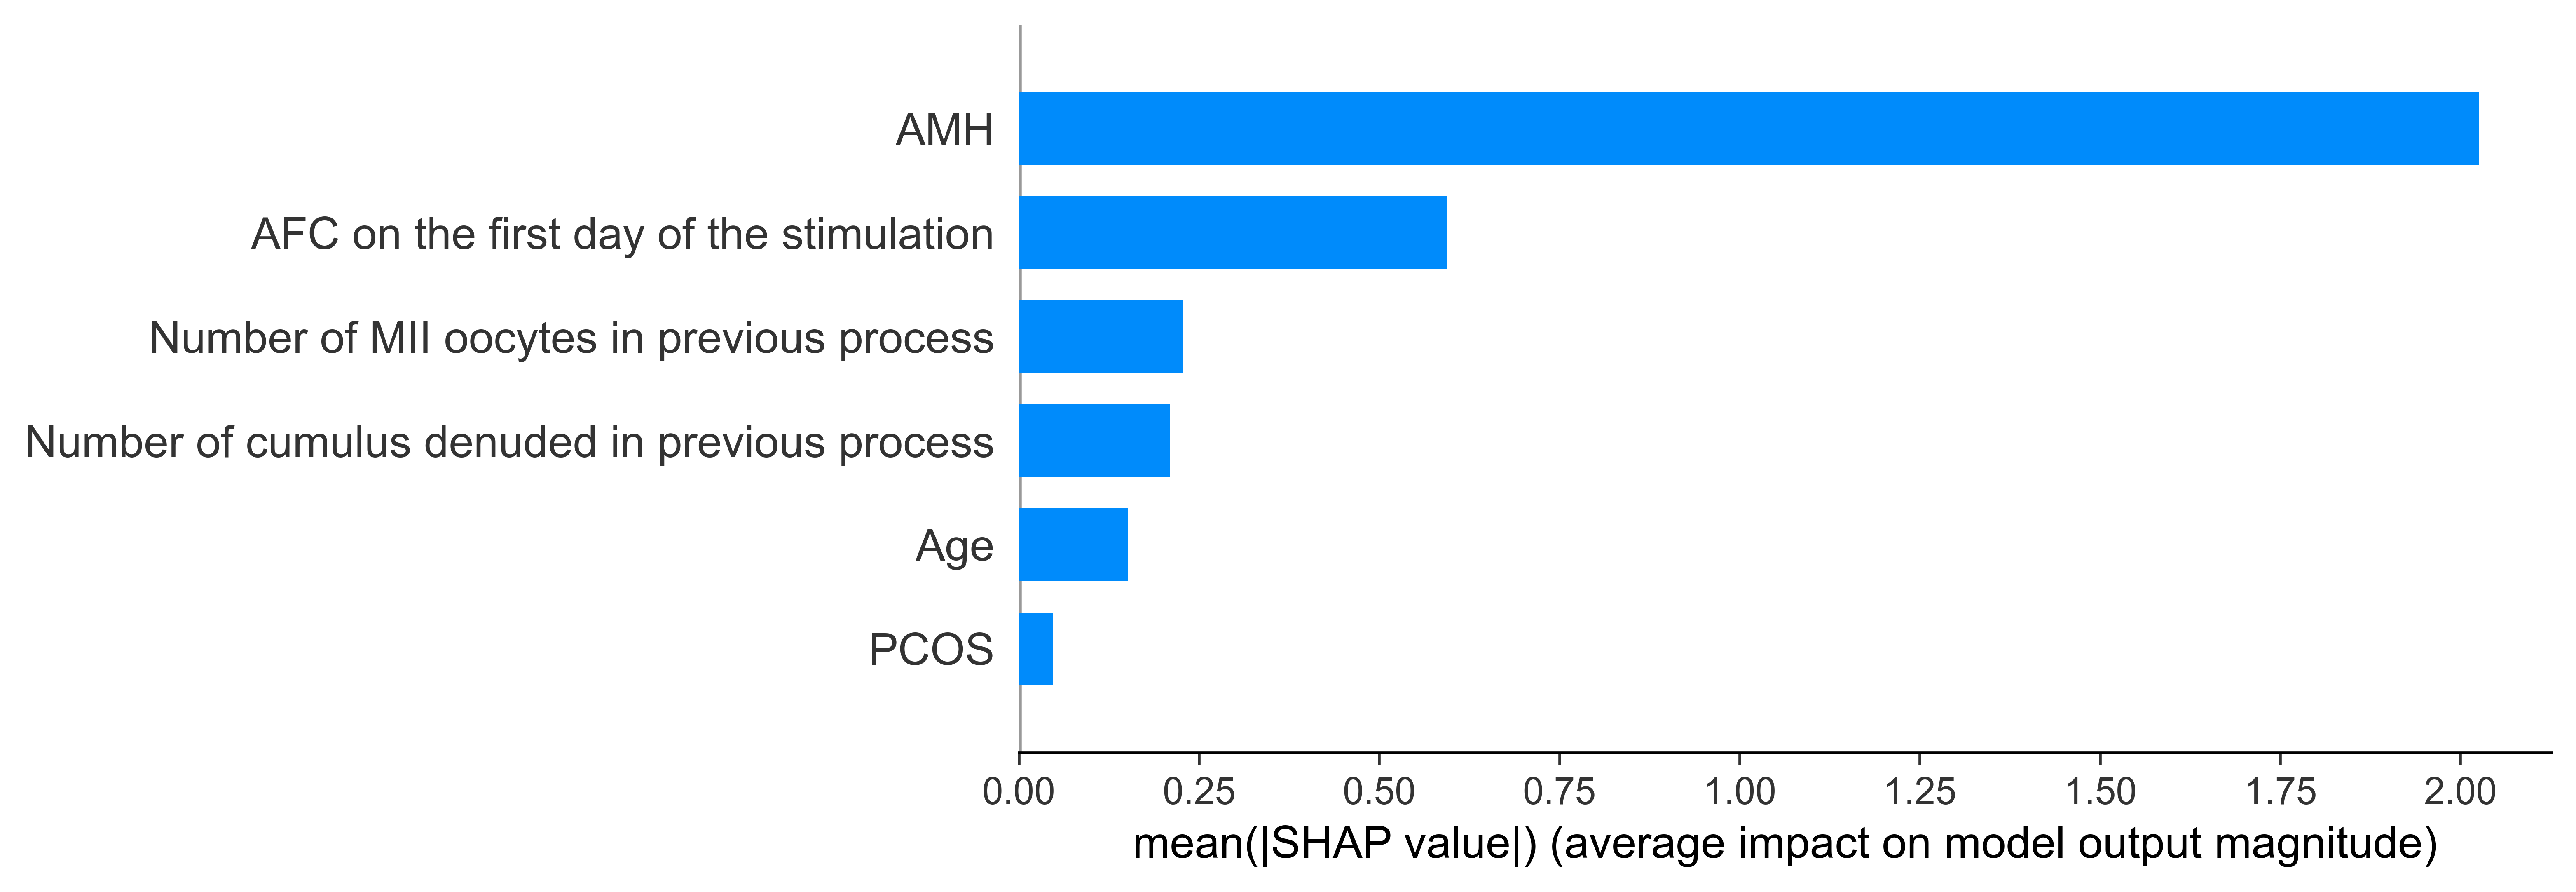

<Figure size 648x792 with 0 Axes>

In [42]:
shap_vals,all_train_dfs, shap_dict_vals = explain_model(
    REF_RESULTS,
    data_serie_name='900_day_0_mii',
    model_suffix='l2',
    folds=range(0, N_FOLDS))

In [28]:
pd.DataFrame(shap_vals).abs().mean()

0    2.025311
1    0.594170
2    0.151782
3    0.209199
4    0.227042
5    0.047256
dtype: float64

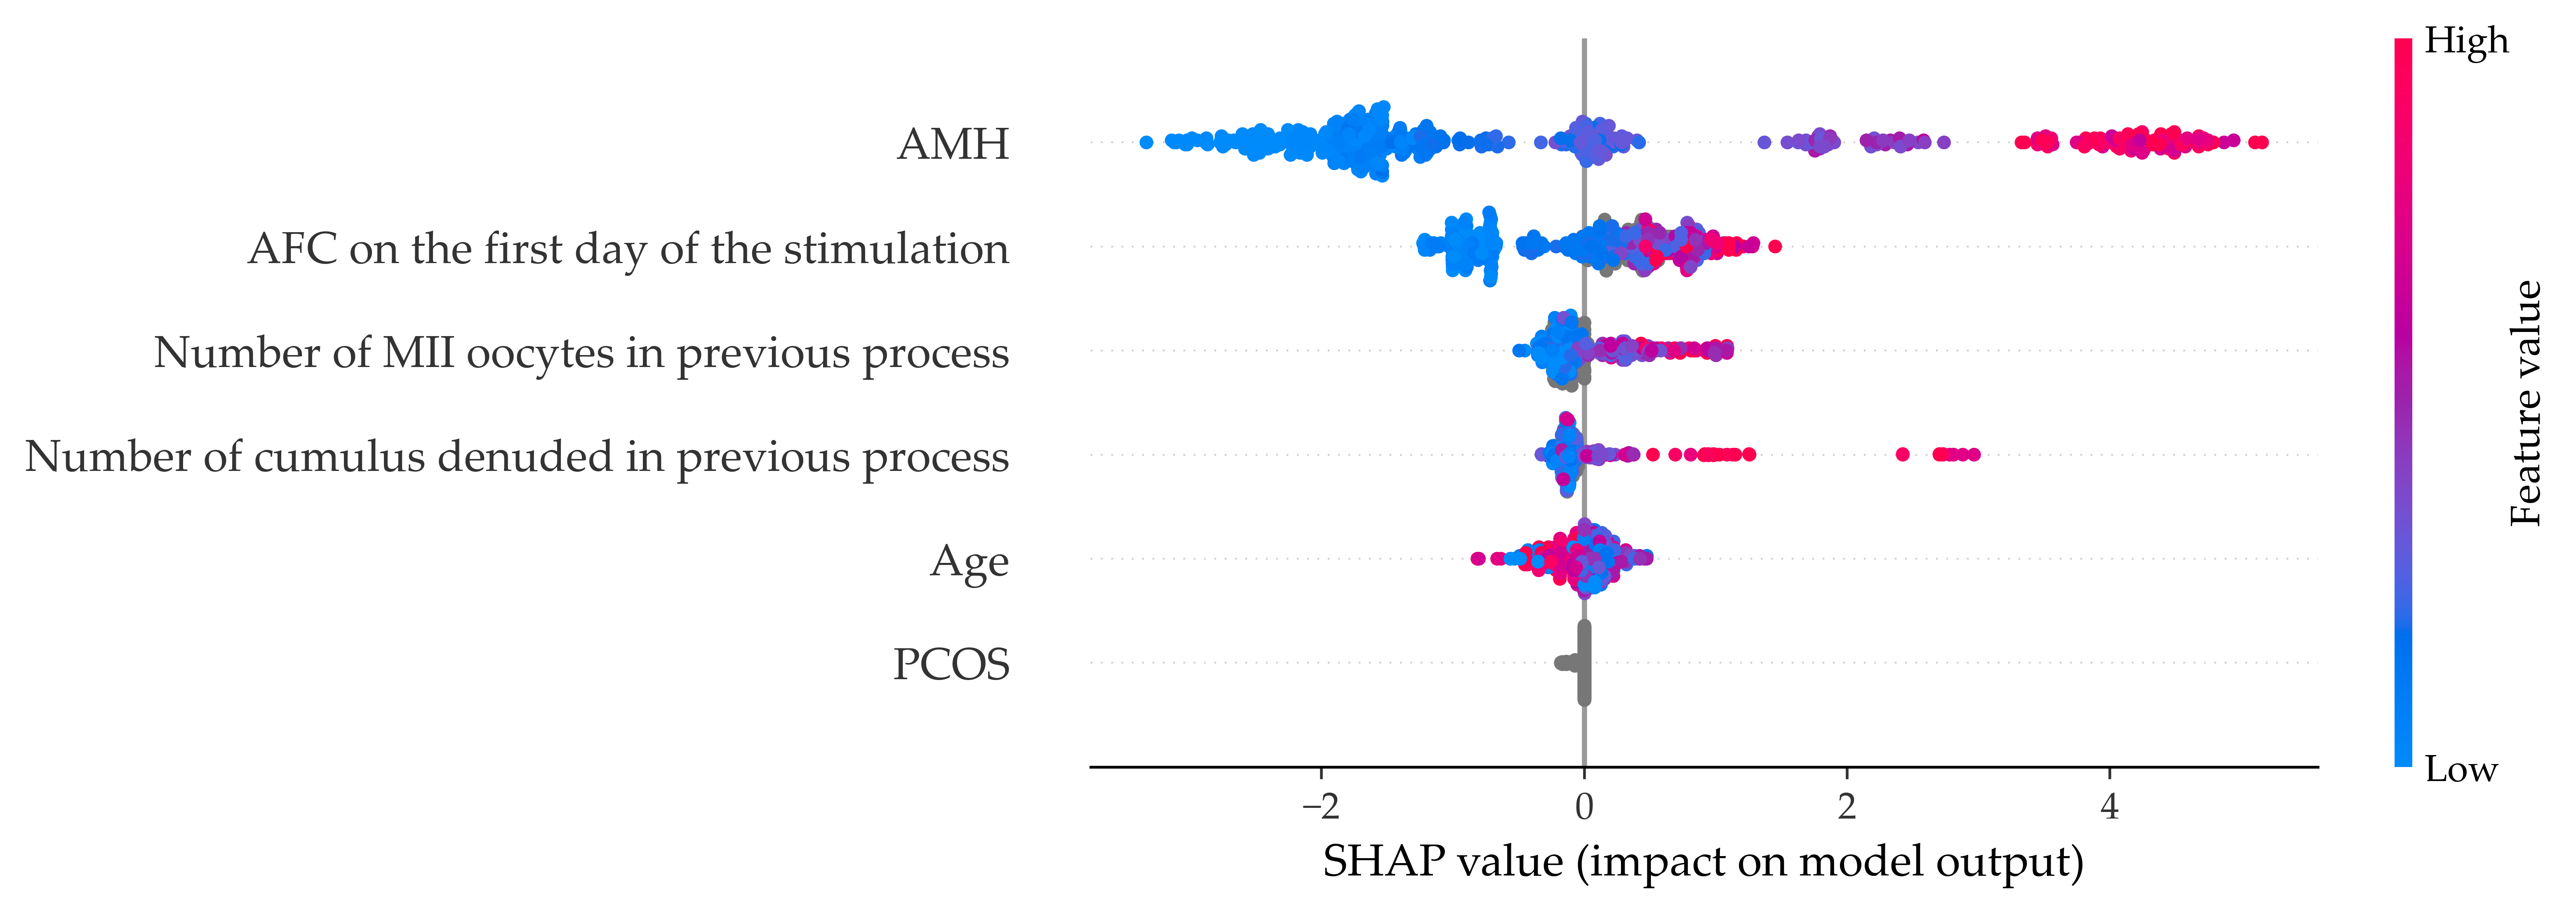

In [112]:
x = pl.figure(figsize=(1, 1), dpi=600)
shap.summary_plot(
    shap_vals,
    all_train_dfs,
    feature_names=REF_COLS,
)
pl.rcParams['font.size'] = 18
pl.show()

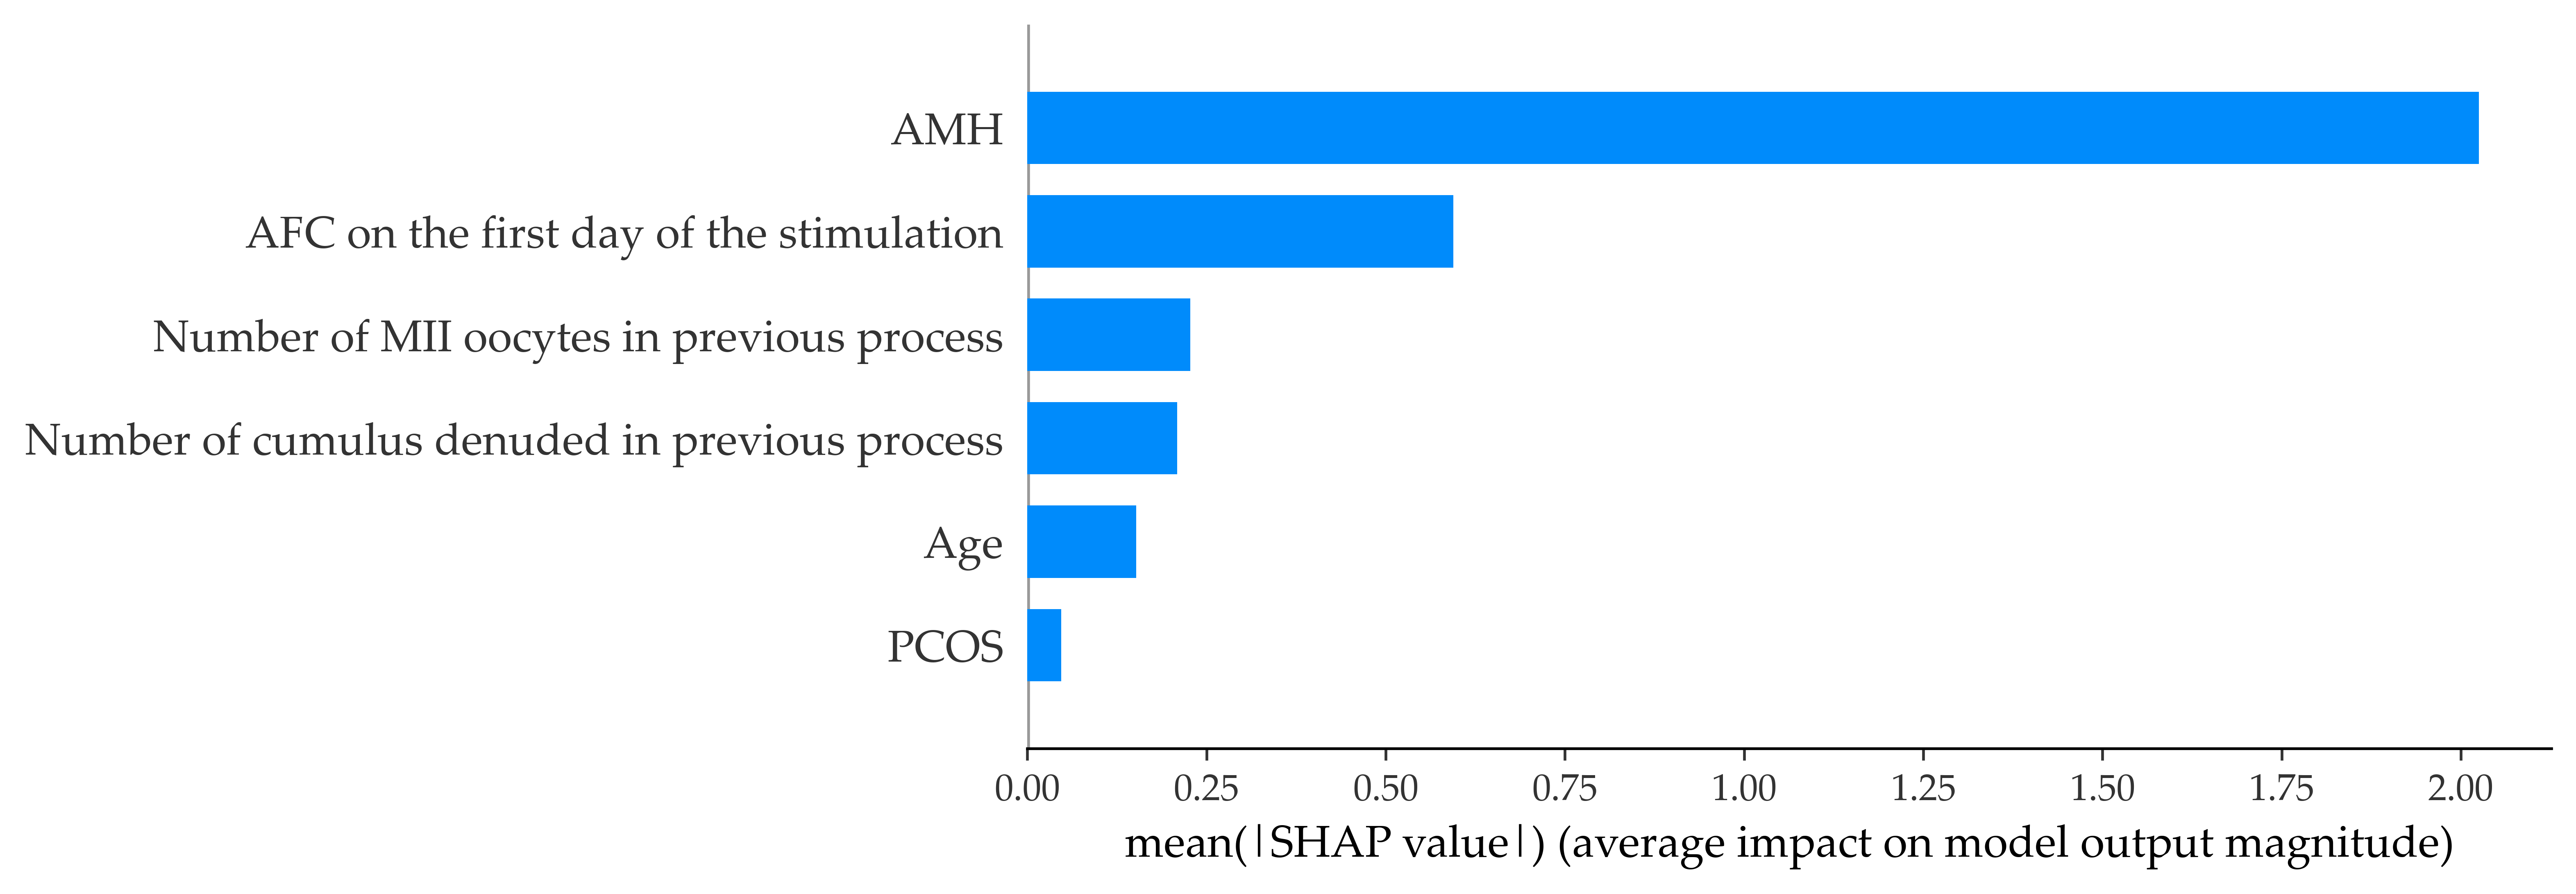

In [115]:
x = pl.figure(figsize=(1, 1), dpi=600)
shap.summary_plot(
    shap_vals,
    all_train_dfs,
    feature_names=REF_COLS,
    plot_type = 'bar'
)
pl.rcParams['font.size'] = 18
pl.show()

## GPS plot

In [29]:
data_900_renamed["IV22-2"] = (
    (data_900_renamed["genome_012_chr2_48962782_C_T"] > 0)
    & (data_900_renamed["genome_012_chr2_48962060_A_G"] == 0)
) * 1

In [30]:
data_900_renamed['IV41-8'] = (data_900_renamed[[
 'genome_012_chr5_35063190_A_T',
 'genome_012_chr5_35064922_C_G',
 'genome_012_chr5_35068146_G_C',
 'genome_012_chr5_35061629_T_C',
 'genome_012_chr5_35069864_G_A',
 'genome_012_chr5_35064413_C_A',
 'genome_012_chr5_35062516_C_T',
 'genome_012_chr5_35065548_C_T'
 ]].sum(axis = 1)==0)*1

In [31]:
data_900_renamed["IV8-6"] = data_900_renamed[
    [
        "GDF9_5_132865538_T_C",
        "GDF9_5_132866205_T_C",
        "LHCGR_2_48729336_C_T",
        "FSHB_11_30234435_A_G",
        "ESR1_6_152061190_A_G",
        "ESR2_14_64227477_C_T"
    ]
].sum(axis=1)

In [32]:
data_900_renamed['IV8-6'] = data_900_renamed[[
"GDF9_5_132865538_T_C",
"GDF9_5_132866205_T_C",
"LHCGR_2_48729336_C_T",
"FSHB_11_30234435_A_G", 
"ESR1_6_152061190_A_G", 
"ESR2_14_64227477_C_T"]].sum(axis = 1)
data_900_renamed['IV8-6'] = (data_900_renamed['IV8-6']-data_900_renamed['IV8-6'].mean())/data_900_renamed['IV8-6'].std()

In [33]:
DATA_SERIES_900 = {}
DATA_SERIES_900['900_day_0_mii'] = prepare_data_serie(data_900_renamed, 'day_0_mii', N_FOLDS)

Original records: 906
Filtered records: 516


In [34]:
GENE_COLS = [
    "AMH",
    "AFC on the first day of the stimulation",
    "Age",
    "Number of cumulus denuded in previous process",
    "Number of MII oocytes in previous process",
    "PCOS",
    "IV22-2",
    "IV41-8",
    "IV8-6"
]

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


-
RMSE[ test_fold_avg][l2][900_day_0_mii]:       count:516    avg:5.92   3.35    (0.00)    
MAE[ test_fold_avg][l2][900_day_0_mii]:        count:516    avg:5.92   2.48    (0.00)    
MAPE[ test_fold_avg][l2][900_day_0_mii]:       count:516    avg:5.92   0.68    (0.00)    
LIKELIHOOD[ test_fold_avg][l2][900_day_0_mii]: count:516    avg:5.92   3.30    (0.00)    
-----------------------------


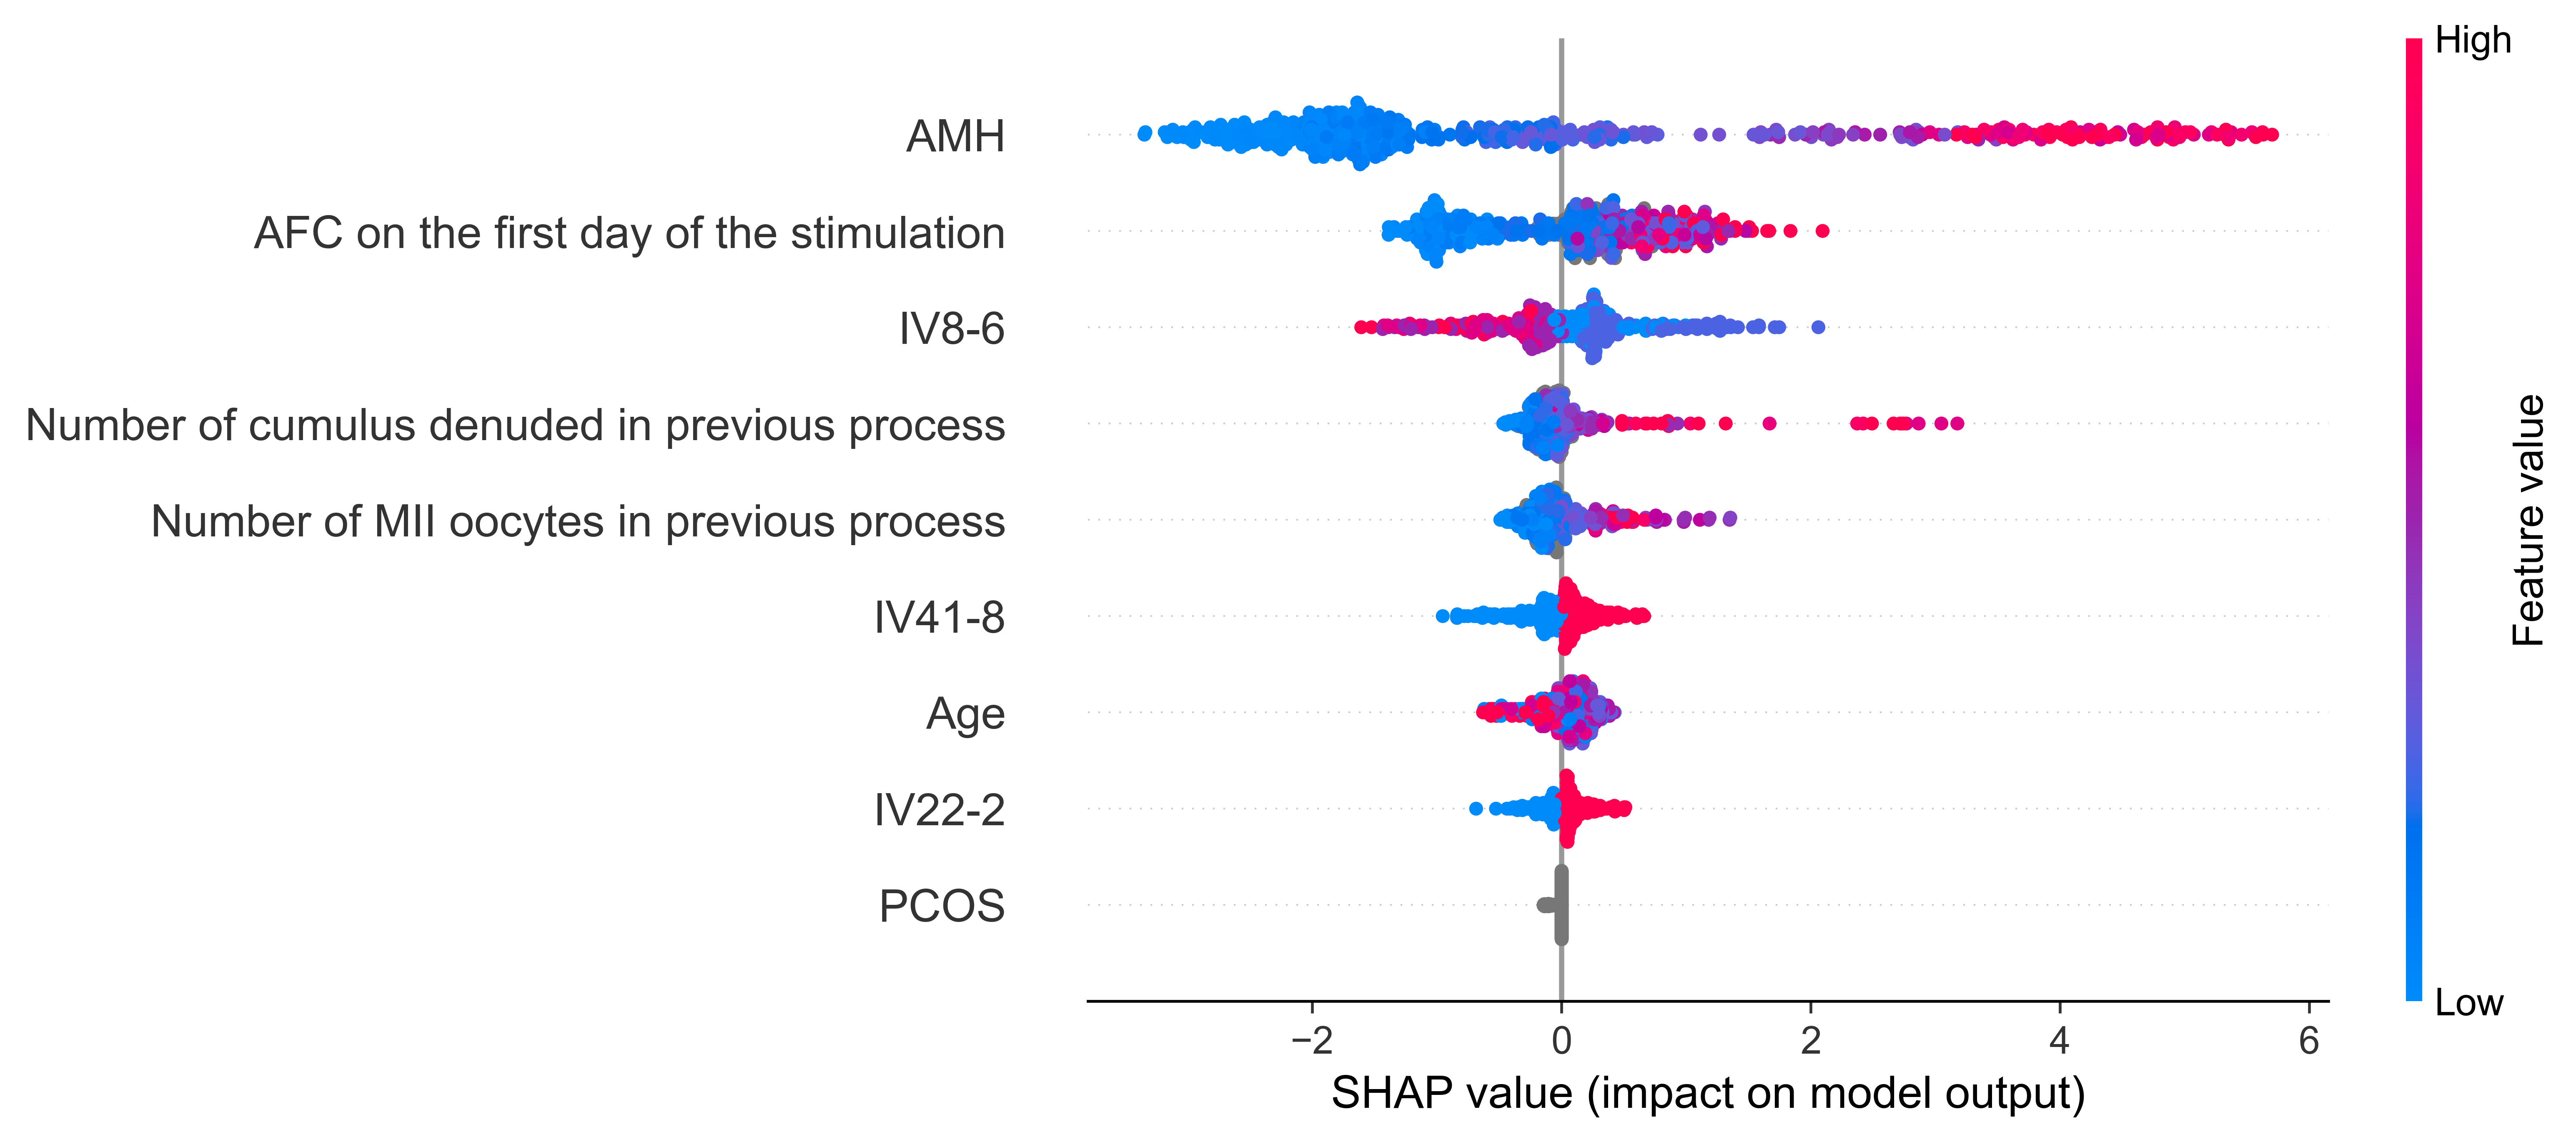

<Figure size 648x792 with 0 Axes>

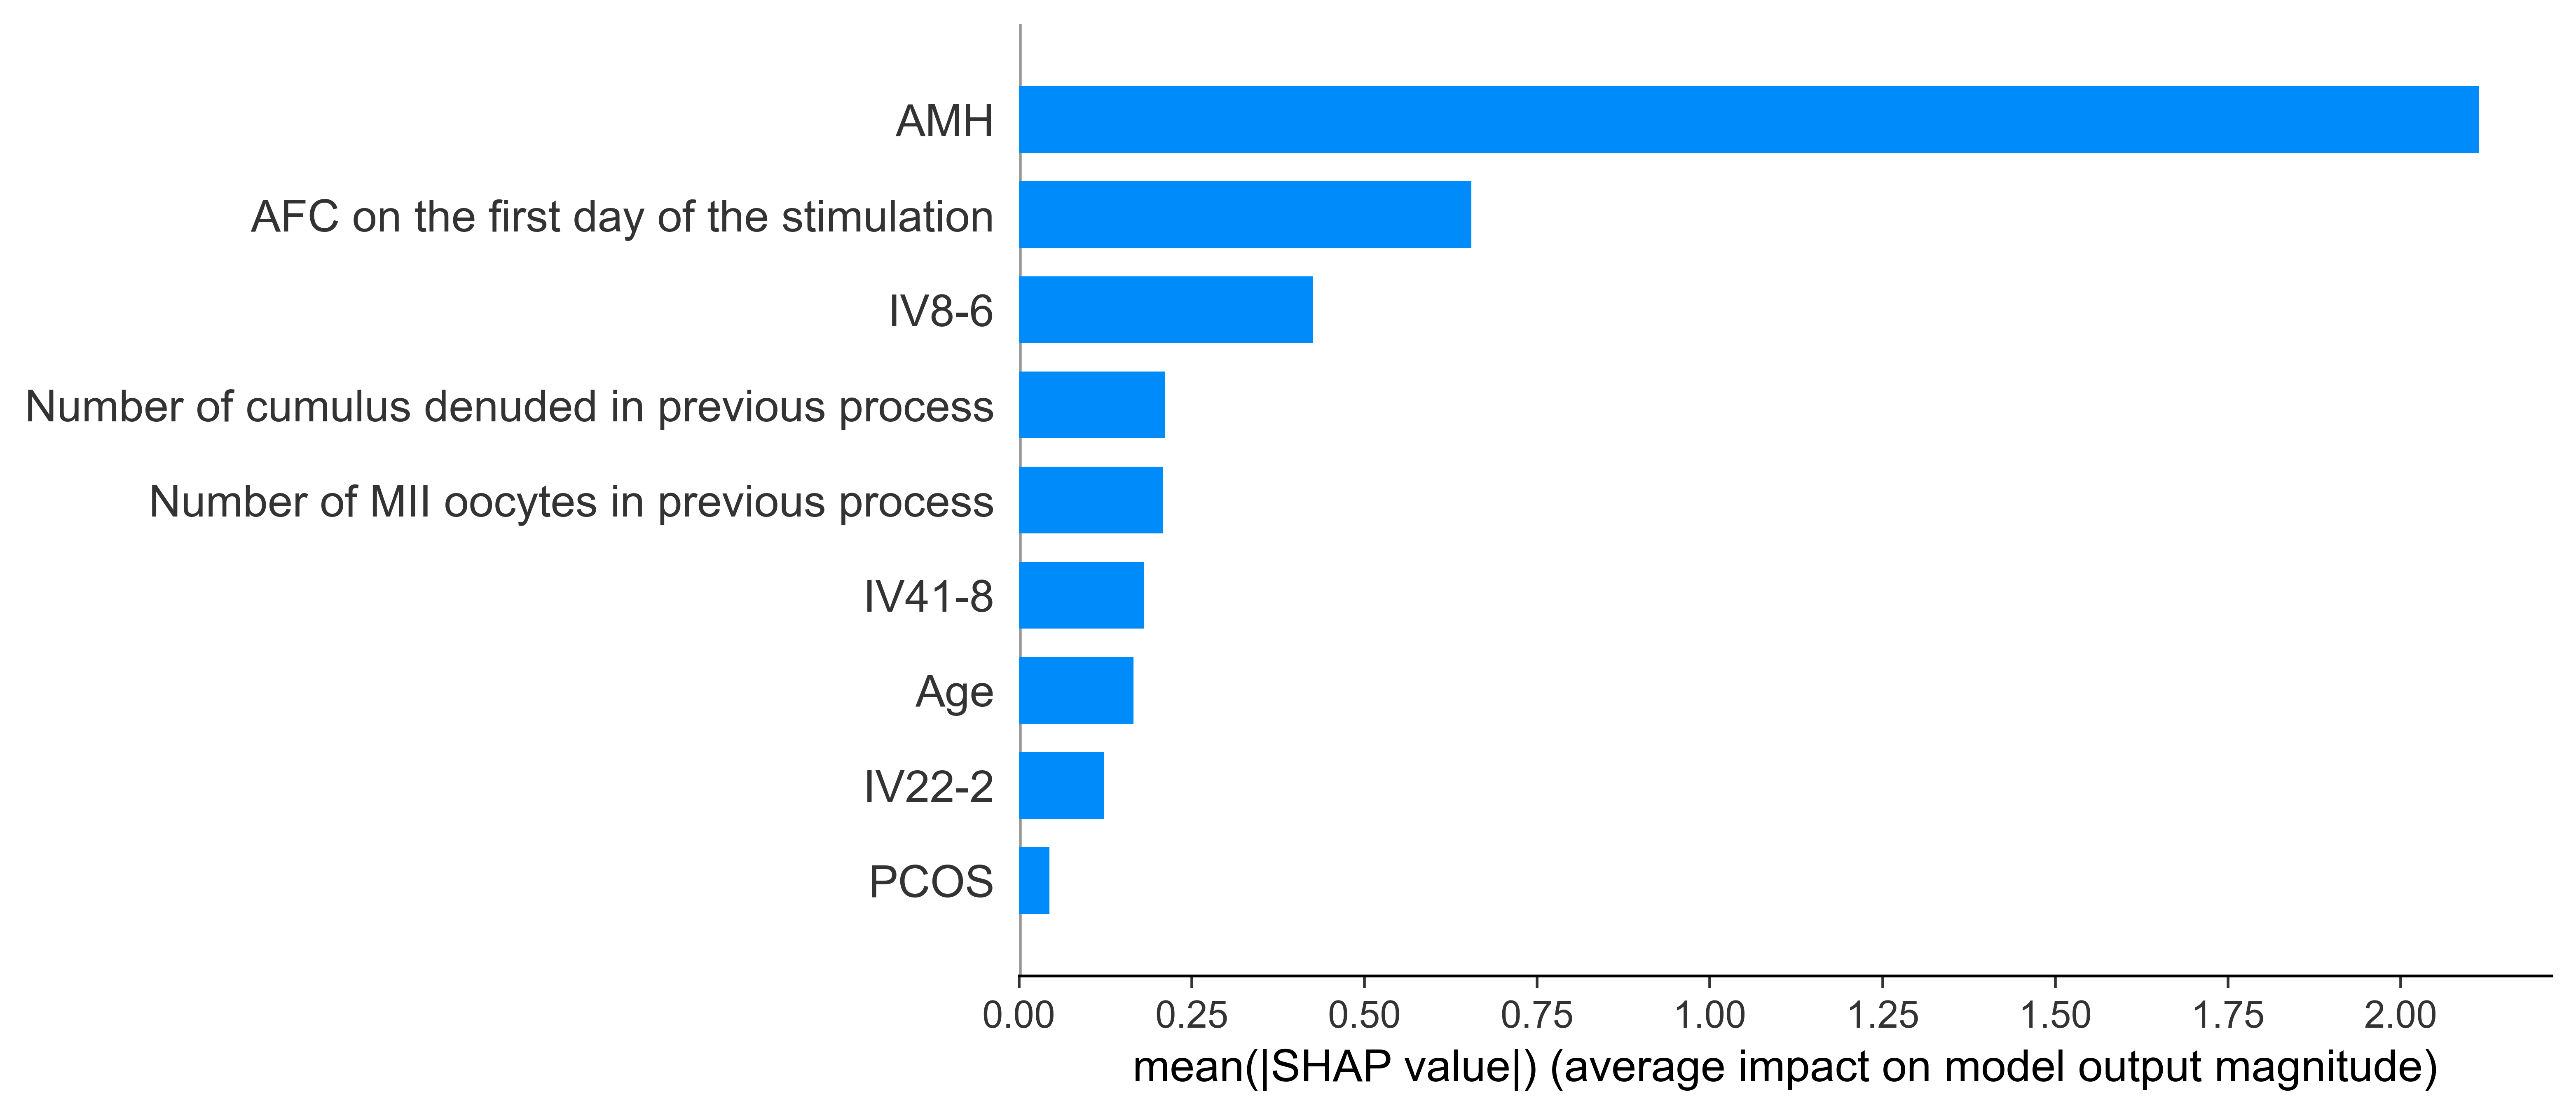

<Figure size 648x792 with 0 Axes>

In [166]:
GENE_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    GENE_COLS,
    model_suffixes_filter=['l2', 'h20', 'h25', 'low', 'upp'])
GENE_RESULTS.print_errors(
    [GENE_RESULTS],
    print_suffixes=['l2'],
    print_avg=True,
)
shap_vals,all_train_dfs, shap_dict = explain_model(
    GENE_RESULTS,
    data_serie_name='900_day_0_mii',
    model_suffix='l2',
    folds=range(0, N_FOLDS),
    shap_dict = True)

In [37]:
pd.DataFrame(shap_vals).abs().mean()

0    2.112879
1    0.655244
2    0.166173
3    0.211296
4    0.208081
5    0.044179
6    0.123373
7    0.181758
8    0.426236
dtype: float64

In [141]:
full_data = []
for key, value in shap_dict.items():
    df = value[0]
    shap_df = value[1]
    df.reset_index(inplace=True, drop=True)
    df_merged = df.merge(
        shap_df, left_index=True, right_index=True
    )
    full_data.append(
        df_merged
    )

In [142]:
full_data = pd.concat(full_data)
full_data.reset_index(inplace = True, drop=True)

In [143]:
GENE_RESULTS_df = GENE_RESULTS.get_merged_test_dfs_from_folds('900_day_0_mii').copy()
GENE_RESULTS_df['error'] = GENE_RESULTS_df['day_0_mii']-GENE_RESULTS_df['prediction_l2']

In [144]:
GENE_RESULTS_df['IV8-6_impact'] = shap_vals[:,8]

<AxesSubplot:>

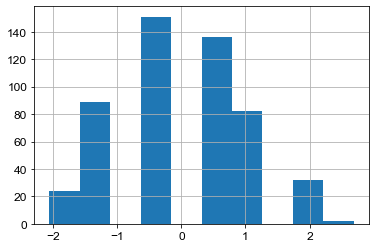

In [216]:
GENE_RESULTS_df['IV8-6'].hist()

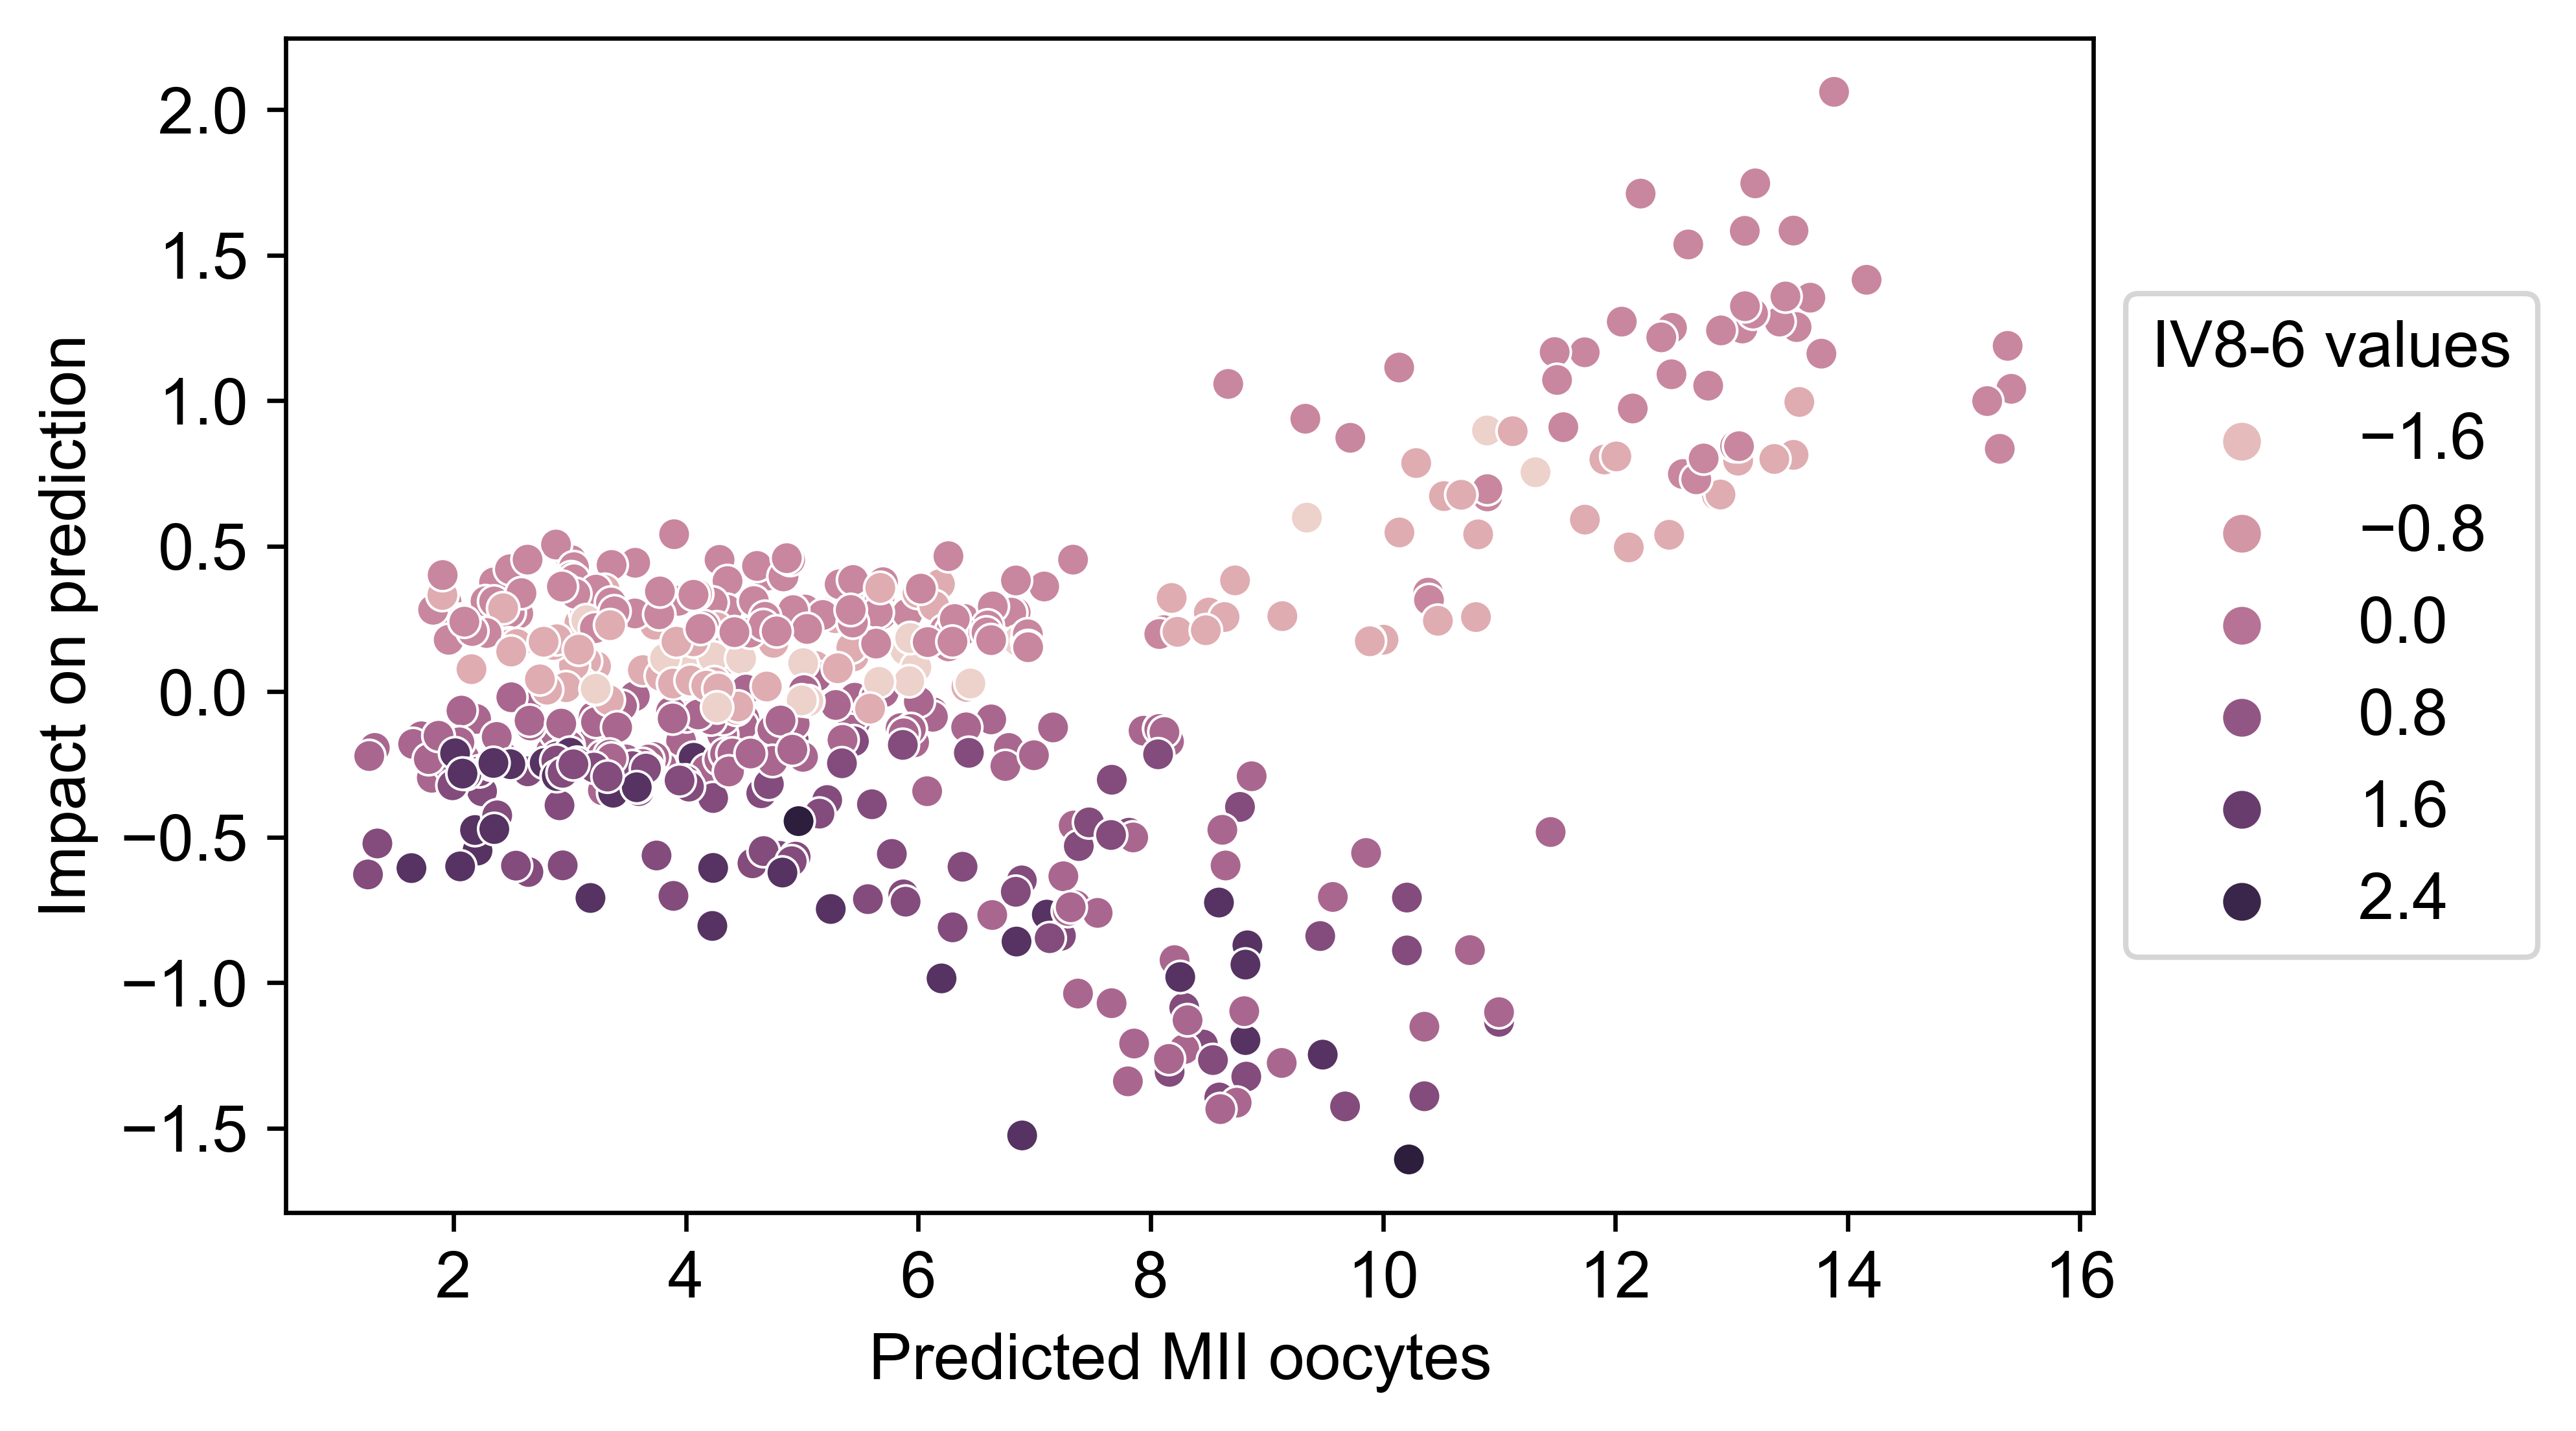

In [146]:
g = plt.figure(dpi=600)
sns.scatterplot(
    y="IV8-6_impact", 
    x="prediction_l2",    
    hue="IV8-6",
    data=full_data,
    x_jitter=.1
)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, title = 'IV8-6 values')
plt.xlabel('Predicted MII oocytes ', fontsize=12)
plt.ylabel('Impact on prediction', fontsize=12)
pl.show()

## Patients - examples

In [158]:
import plotly.figure_factory as ff

In [148]:
accurate_predictions = full_data.loc[abs(full_data.day_0_mii - full_data.prediction_l2)<1].copy()

In [149]:
accurate_predictions.reset_index(inplace = True, drop = True)

In [151]:
biggest_percentage_genes_impact = accurate_predictions.iloc[
    np.where(
        abs(accurate_predictions.loc[:,['IV22-2_impact','IV41-8_impact','IV8-6_impact']]).sum(axis=1) > 1
    )[0]
]

Plots

In [154]:
from lib.shap_utils import shap_waterfall_plots

In [155]:
full_data.loc[full_data.process_number=="IVF/01/2015/0142"][[
"GDF9_5_132865538_T_C",
"GDF9_5_132866205_T_C",
"LHCGR_2_48729336_C_T",
"FSHB_11_30234435_A_G", 
"ESR1_6_152061190_A_G", 
"ESR2_14_64227477_C_T",
"day_0_mii"]]

GDF9_5_132865538_T_C  GDF9_5_132866205_T_C  LHCGR_2_48729336_C_T  \
255                  True                 False                  True   

     FSHB_11_30234435_A_G  ESR1_6_152061190_A_G  ESR2_14_64227477_C_T  \
255                  True                 False                  True   

     day_0_mii  
255        3.0

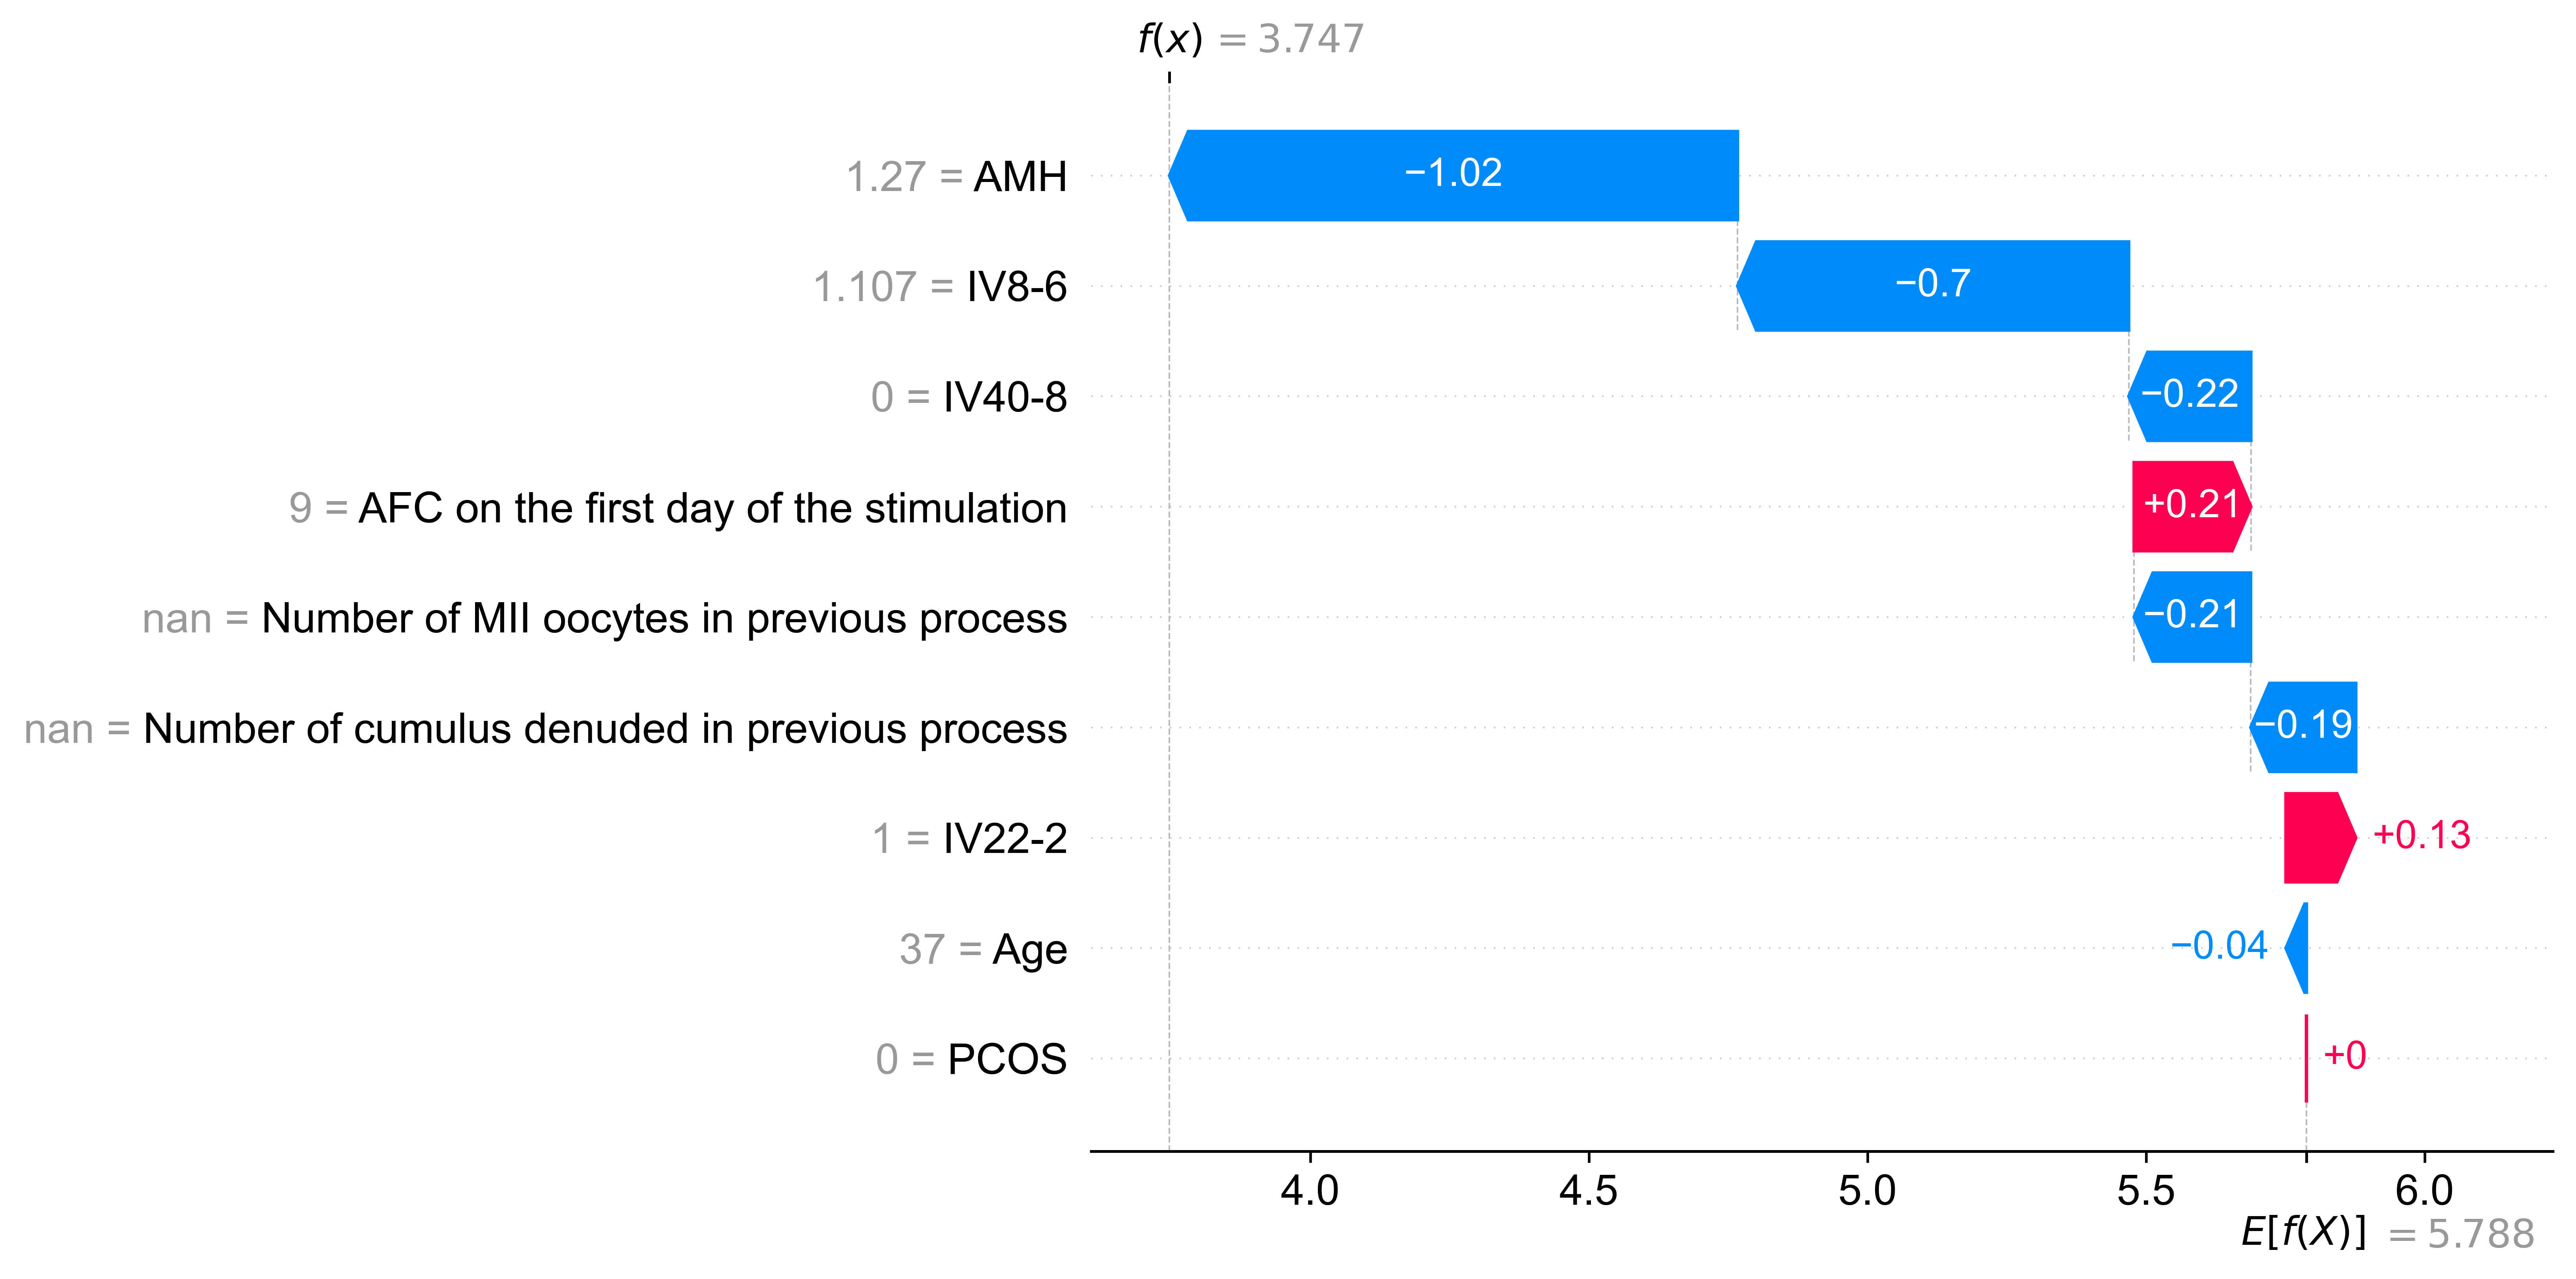

<Figure size 648x792 with 0 Axes>

In [156]:
shap_waterfall_plots(
    train_results=GENE_RESULTS,
    data_serie_name="900_day_0_mii",
    folds=range(0, 5),
    number_of_cases=1,
    filter_tuple=("process_number", "IVF/01/2015/0142"),
)

In [374]:
full_data.loc[full_data.process_number=="IVF/12/2013/0007"][[
"GDF9_5_132865538_T_C",
"GDF9_5_132866205_T_C",
"LHCGR_2_48729336_C_T",
"FSHB_11_30234435_A_G", 
"ESR1_6_152061190_A_G", 
"ESR2_14_64227477_C_T",
"day_0_mii"]]

GDF9_5_132865538_T_C  GDF9_5_132866205_T_C  LHCGR_2_48729336_C_T  \
240                 False                 False                  True   

     FSHB_11_30234435_A_G  ESR1_6_152061190_A_G  ESR2_14_64227477_C_T  \
240                 False                 False                  True   

     day_0_mii  
240       13.0

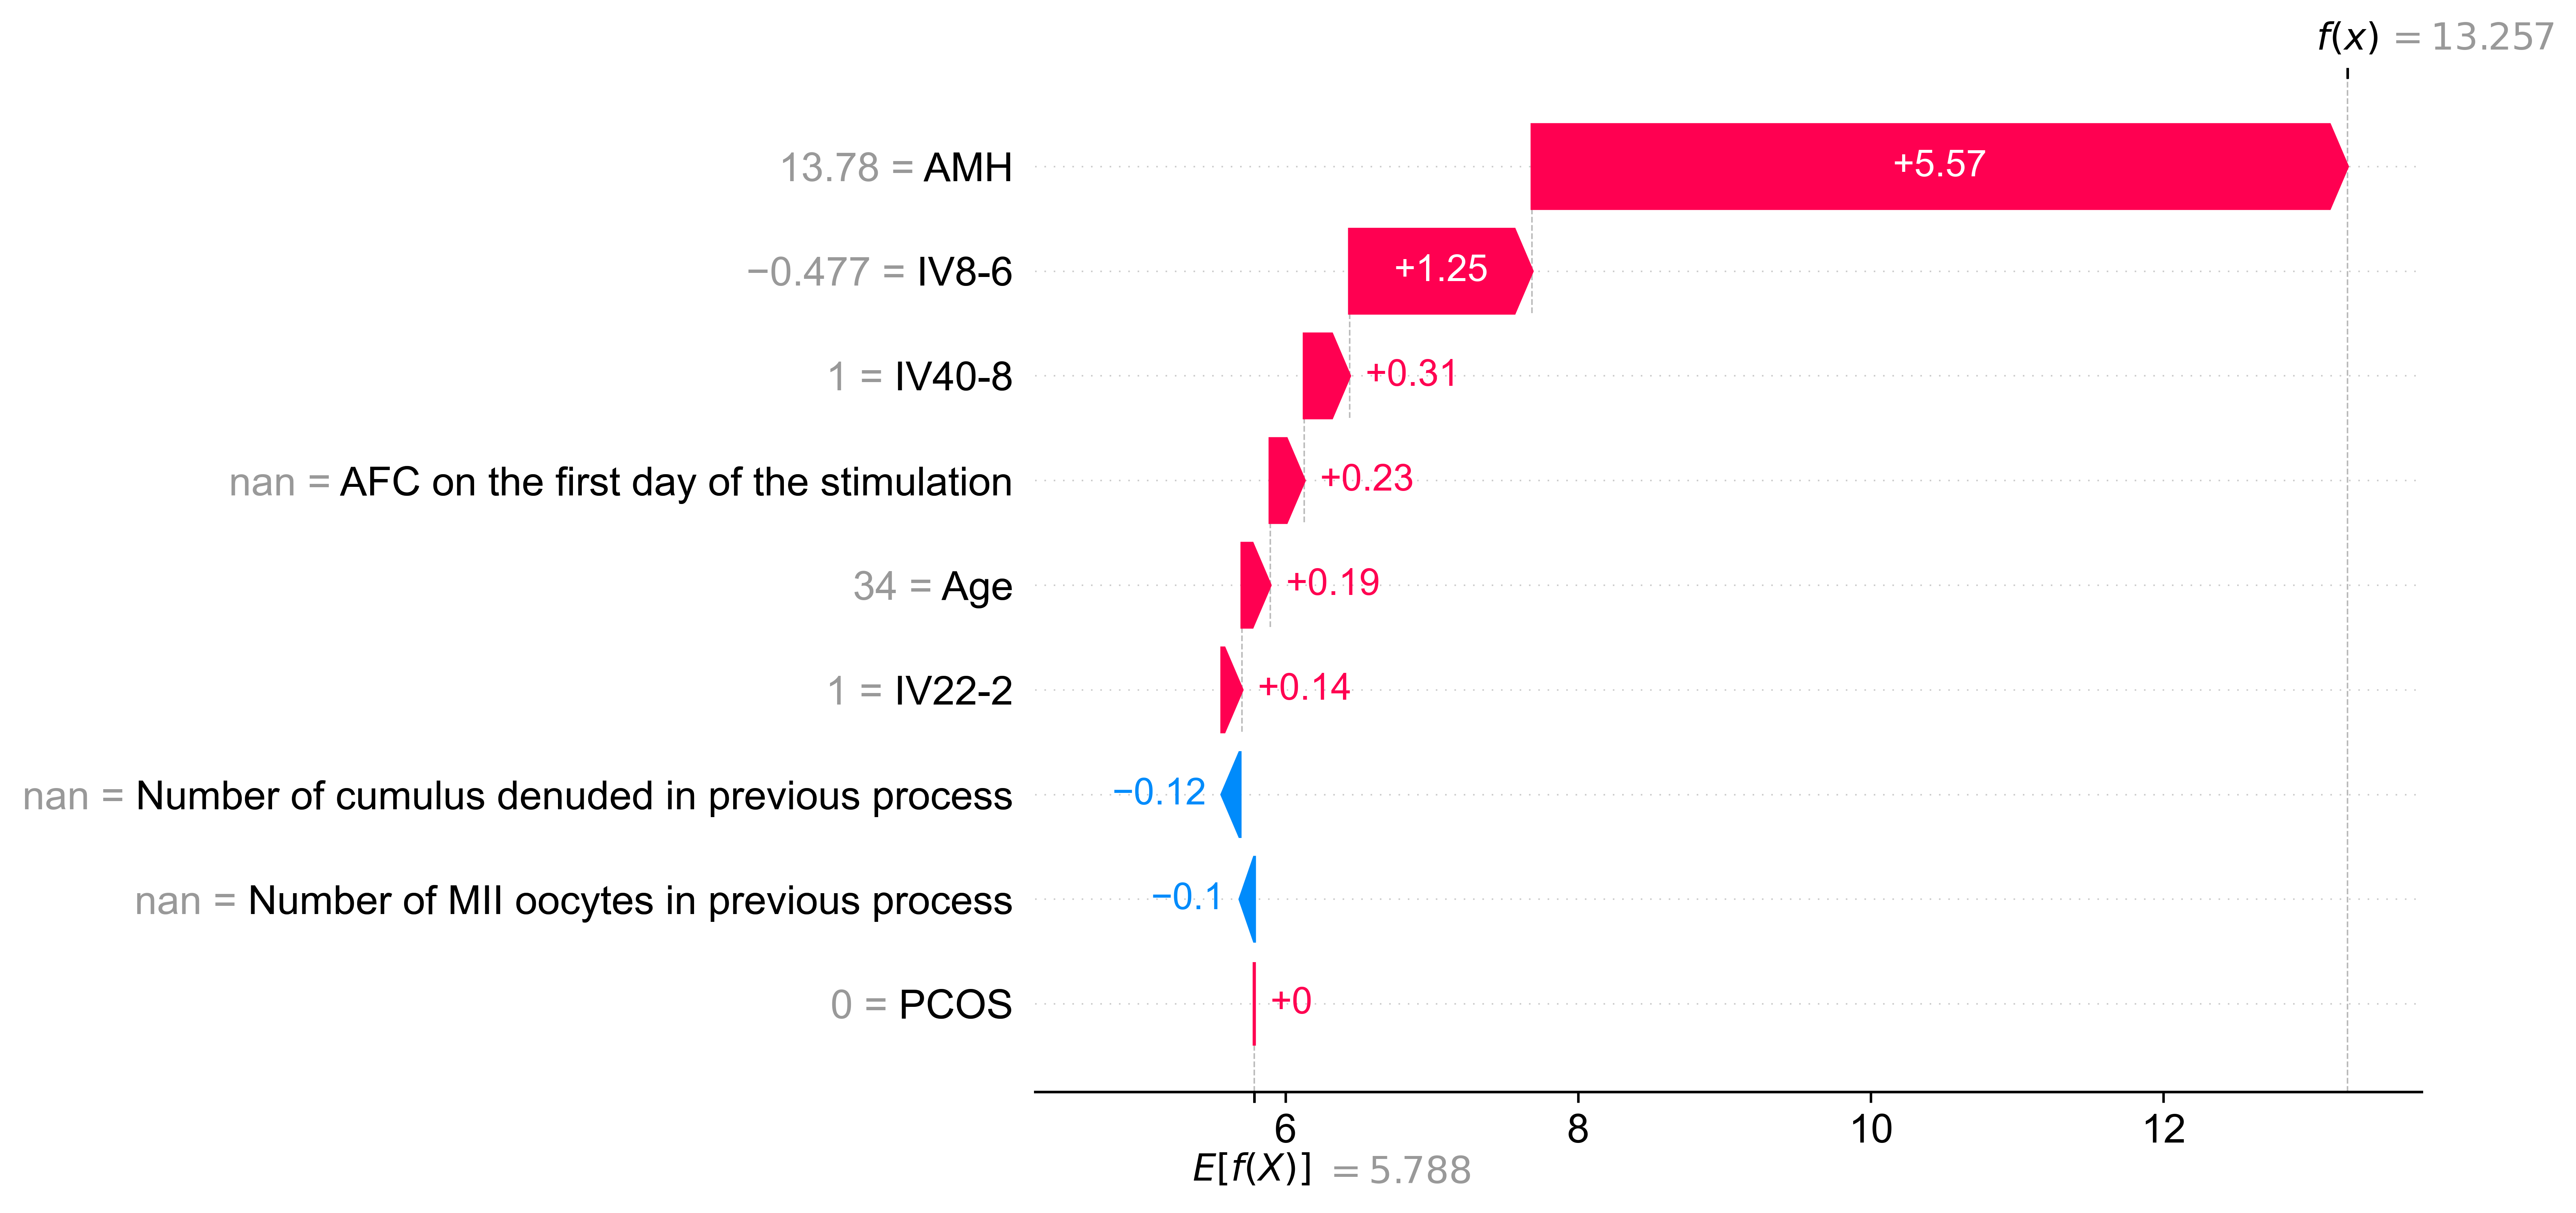

<Figure size 648x792 with 0 Axes>

In [157]:
shap_waterfall_plots(
    train_results=GENE_RESULTS,
    data_serie_name="900_day_0_mii",
    folds=range(0, 5),
    number_of_cases=1,
    filter_tuple=("process_number", "IVF/12/2013/0007"),
)